# DIISCO RL Interactions in CAR T

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
import pickle5 as pickle
import omnipath
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import glob
import scanpy as sc

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Load gene expression data

In [2]:
hours_post_coculture = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
hours_post_coculture = {i: hour for i, hour in enumerate(hours_post_coculture)}
cell_types = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']
cell_types_to_cluster_numbers = {
    'Other CD8+ T cells': [19,28],
    'MEC1 cells': [1,7,8,10,16,17,22,23,24],
    'Activated T cells': [3,12,14],
    'Exhausted T cells': [0,6,9,11,15,21,26]
}
cluster_numbers_to_cell_types = {cluster_number: cell_type 
                                 for cell_type, cluster_numbers in cell_types_to_cluster_numbers.items()
                                 for cluster_number in cluster_numbers}

gene_exp_df = pickle.load(open('data/CAR-T ratios and umap/data_df_revised_clusters.pkl', 'rb'))
# Filter to experiment C
gene_exp_df = gene_exp_df[gene_exp_df.index.str.startswith('CARC')]
gene_exp_df = gene_exp_df[gene_exp_df['cluster_number'].isin(cluster_numbers_to_cell_types.keys())]
gene_exp_df['cell_type'] = gene_exp_df['cluster_number'].replace(cluster_numbers_to_cell_types)
gene_exp_df['timestamp'] = [int(index_split[1][1]) 
                            for index_split in gene_exp_df.index.str.split('_')]
gene_exp_df['timestamp'] = gene_exp_df['timestamp'].replace(hours_post_coculture)
genes = gene_exp_df.columns[:-3]
gene_exp_df

MIR1302-2HG  AL627309.1  AL669831.5    FAM87B  \
CARC_T8_AAACCTGAGAAGGCCT    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_AAACCTGAGACAAGCC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T6_AAACCTGAGACAATAC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_AAACCTGAGCCATCGC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG    -2.302585   -2.302585   -2.302585 -2.302585   
...                               ...         ...         ...       ...   
CARC_T9_TTTGTCATCATGTAGC    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA    -2.302585   -2.302585   -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT    -2.302585   -2.302585   -2.302585 -2.302585   

                          LINC00115    FAM41C  AL645608.7  AL645608.3  \
CARC_T8_AAACCTGAGAAGGCCT  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG  -2.302585 -2.302585   -2.302585   -2.302585   
...                             ...       ...         ...         ...   
CARC_T9_TTTGTCATCATGTAGC  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG  -0.744831 -2.302585   -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA  -2.302585 -2.302585   -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT  -2.302585 -2.302585   -2.302585   -2.302585   

                            SAMD11     NOC2L  ...     MAFIP  AC011043.1  \
CARC_T8_AAACCTGAGAAGGCCT -2.302585 -2.302585  ... -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC -2.302585 -2.302585  ... -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC -2.302585 -2.302585  ... -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC -2.302585 -0.633307  ... -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -2.302585 -0.990700  ... -2.302585   -2.302585   
...                            ...       ...  ...       ...         ...   
CARC_T9_TTTGTCATCATGTAGC -2.302585 -2.302585  ... -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585 -0.445403  ... -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG -2.302585 -2.302585  ... -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA -2.302585 -2.302585  ... -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT -2.302585 -0.281202  ... -2.302585   -2.302585   

                          AL592183.1  AL354822.1  AC004556.1  AC233755.1  \
CARC_T8_AAACCTGAGAAGGCCT   -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC   -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC   -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC   -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG   -2.302585   -2.302585   -2.302585   -2.302585   
...                              ...         ...         ...         ...   
CARC_T9_TTTGTCATCATGTAGC   -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA   -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG   -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA   -2.302585   -2.302585   -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT   -2.302585   -2.302585   -2.302585   -2.302585   

                          AC240274.1  cluster_number          cell_type  \
CARC_T8_AAACCTGAGAAGGCCT   -2.302585              12  Activated T cells   
CARC_T9_AAACCTGAGACAAGCC   -2.302585               3  Activated T cells   
CARC_T6_AAACCTGAGACAATAC   -2.302585               3  Activated T cells   
CARC_T9_AAACCTGAGCCATCGC   -2.302585              10         MEC1 cells   
CARC_T2_AAACCTGAGGTAGCTG   -2.302585              17       

Filter genes with low expression

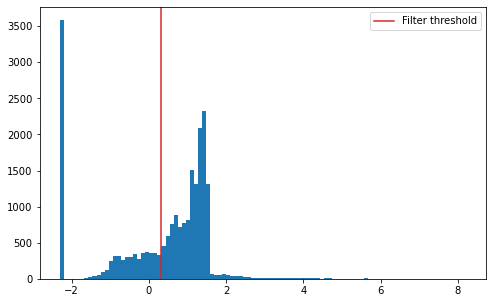

In [3]:
threshold = 0.3

plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(gene_exp_df[genes].max(), bins=100)
plt.axvline(threshold, label='Filter threshold', c='tab:red')
plt.legend()

In [4]:
print("Percent genes removed:", (gene_exp_df[genes].max() <= threshold).mean() * 100)

gene_filter = (gene_exp_df[genes].max() <= threshold)
genes = genes[~gene_filter]
gene_exp_df = gene_exp_df.drop(columns=gene_filter[gene_filter].index)
gene_exp_df

Percent genes removed: 35.8975509105589


AL669831.5  LINC00115    FAM41C     NOC2L    KLHL17  \
CARC_T8_AAACCTGAGAAGGCCT   -2.302585  -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGAGACAAGCC   -2.302585  -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T6_AAACCTGAGACAATAC   -2.302585  -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGAGCCATCGC   -2.302585  -2.302585 -2.302585 -0.633307 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG   -2.302585  -2.302585 -2.302585 -0.990700 -2.302585   
...                              ...        ...       ...       ...       ...   
CARC_T9_TTTGTCATCATGTAGC   -2.302585  -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA   -2.302585  -2.302585 -2.302585 -0.445403 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG   -2.302585  -0.744831 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA   -2.302585  -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT   -2.302585  -2.302585 -2.302585 -0.281202 -2.302585   

                           PLEKHN1     PERM1     ISG15      AGRN  C1orf159  \
CARC_T8_AAACCTGAGAAGGCCT -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGAGACAAGCC -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T6_AAACCTGAGACAATAC -2.302585 -2.302585  0.117269 -2.302585 -2.302585   
CARC_T9_AAACCTGAGCCATCGC -2.302585 -2.302585 -0.039088 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -2.302585 -2.302585  0.169968 -2.302585 -2.302585   
...                            ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCATGTAGC -2.302585 -2.302585  1.648138 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585 -2.302585 -0.445403 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG -2.302585 -2.302585 -0.744831 -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT -2.302585 -2.302585  0.343413 -2.302585 -2.302585   

                          ...    MT-ND6    MT-CYB     MAFIP  AC011043.1  \
CARC_T8_AAACCTGAGAAGGCCT  ...  0.202868  3.453078 -2.302585   -2.302585   
CARC_T9_AAACCTGAGACAAGCC  ... -2.302585  3.312464 -2.302585   -2.302585   
CARC_T6_AAACCTGAGACAATAC  ... -0.490678  2.670134 -2.302585   -2.302585   
CARC_T9_AAACCTGAGCCATCGC  ... -0.039088  3.094332 -2.302585   -2.302585   
CARC_T2_AAACCTGAGGTAGCTG  ... -0.442180  3.253281 -2.302585   -2.302585   
...                       ...       ...       ...       ...         ...   
CARC_T9_TTTGTCATCATGTAGC  ... -2.302585  3.882065 -2.302585   -2.302585   
CARC_T9_TTTGTCATCGACGGAA  ... -0.093378  3.040313 -2.302585   -2.302585   
CARC_T9_TTTGTCATCGGCTTGG  ...  0.202486  3.150104 -2.302585   -2.302585   
CARC_T7_TTTGTCATCGTGGGAA  ... -2.302585  3.247368 -2.302585   -2.302585   
CARC_T8_TTTGTCATCTTCATGT  ... -0.281202  2.529134 -2.302585   -2.302585   

                          AL592183.1  AL354822.1  AC004556.1  cluster_number  \
CARC_T8_AAACCTGAGAAGGCCT   -2.302585   -2.302585   -2.302585              12   
CARC_T9_AAACCTGAGACAAGCC   -2.302585   -2.302585   -2.302585               3   
CARC_T6_AAACCTGAGACAATAC   -2.302585   -2.302585   -2.302585               3   
CARC_T9_AAACCTGAGCCATCGC   -2.302585   -2.302585   -2.302585              10   
CARC_T2_AAACCTGAGGTAGCTG   -2.302585   -2.302585   -2.302585              17   
...                              ...         ...         ...             ...   
CARC_T9_TTTGTCATCATGTAGC   -2.302585   -2.302585   -2.302585              17   
CARC_T9_TTTGTCATCGACGGAA   -2.302585   -2.302585   -2.302585              15   
CARC_T9_TTTGTCATCGGCTTGG   -2.302585   -2.302585   -2.302585              15   
CARC_T7_TTTGTCATCGTGGGAA   -2.302585   -2.302585   -2.302585               9   
CARC_T8_TTTGTCATCTTCATGT   -2.302585   -2.302585   -2.302585               9   

                                  cell_type  timestamp  
CARC_T8_AAACCTGAGAAGGCCT  Activated T cells      12.50  
CARC_T9_AAACCTGAGACAAGCC  Activated T cells      20.50  
CARC_T6_AAACCTGAGACAATAC  Activated T cells       4.00  
CARC_T9_AAACCTGAGCCATCGC  

Differentially expressed genes, by cluster

In [5]:
gene_exp_adata = sc.AnnData(gene_exp_df[genes], 
                            obs=gene_exp_df[['cell_type']].astype('str'))
sc.tl.rank_genes_groups(gene_exp_adata, groupby='cell_type', method='wilcoxon', key_added='wilcoxon')

In [6]:
cluster_deg_df = sc.get.rank_genes_groups_df(gene_exp_adata, group='Exhausted T cells', key='wilcoxon')
top_degs = cluster_deg_df[(cluster_deg_df['pvals_adj'] <= 0.01) & (cluster_deg_df['scores'] >= 0)]
top_degs.head(10)

names     scores  logfoldchanges  pvals  pvals_adj
0    EIF5A  80.315643        2.798494    0.0        0.0
1    PSMB1  79.544975        1.985841    0.0        0.0
2    FABP5  79.112114        4.529797    0.0        0.0
3    IL2RA  78.791855             NaN    0.0        0.0
4     EID1  78.747780        1.601136    0.0        0.0
5    PSMB6  78.563713        4.274839    0.0        0.0
6  SLC25A3  78.497520        1.279457    0.0        0.0
7    C1QBP  78.264687        2.863290    0.0        0.0
8   TIMM8B  77.994324             NaN    0.0        0.0
9   ZNF706  77.764465        2.858510    0.0        0.0

In [7]:
cluster_to_degs = dict()
clusters = sorted(gene_exp_df['cell_type'].unique())
for cluster in clusters:
    cluster_deg_df = sc.get.rank_genes_groups_df(gene_exp_adata, group=str(cluster), key='wilcoxon')
    top_degs = cluster_deg_df[(cluster_deg_df['pvals_adj'] <= 0.01) & 
                              (cluster_deg_df['scores'] >= 0)]
    cluster_to_degs[cluster] = {
        deg['names']: deg['pvals_adj']
        for index, deg in top_degs.iterrows()
    }

Load receptor-ligand pairs from Omnipath DB

In [8]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])
# rl_pairs.to_csv('data/RL_pairs/Omnipath_RL_pairs.csv', index=False)
# Filter RL pairs to genes in gene expression data
rl_pairs = rl_pairs[(rl_pairs['source_genesymbol'].isin(gene_exp_df.columns)) & 
                    (rl_pairs['target_genesymbol'].isin(gene_exp_df.columns))]
rl_pairs

source  target source_genesymbol target_genesymbol  is_directed  \
2     O60674  P19235              JAK2              EPOR         True   
7     P05019  P08069              IGF1             IGF1R         True   
8     P46531  P78504            NOTCH1              JAG1         True   
9     P78504  P46531              JAG1            NOTCH1         True   
15    Q9GZX6  Q08334              IL22            IL10RB         True   
...      ...     ...               ...               ...          ...   
8296  Q01974  Q9NPG1              ROR2              FZD3         True   
8297  P34925  Q9NPG1               RYK              FZD3         True   
8304  Q01974  O60353              ROR2              FZD6         True   
8305  P34925  O60353               RYK              FZD6         True   
8322  P09486  Q9GZP0             SPARC             PDGFD         True   

      is_stimulation  is_inhibition  consensus_direction  \
2               True          False                 True   
7               True          False                 True   
8               True          False                False   
9               True           True                 True   
15              True          False                 True   
...              ...            ...                  ...   
8296            True          False                 True   
8297            True          False                 True   
8304            True          False                 True   
8305            True          False                 True   
8322           False           True                 True   

      consensus_stimulation  consensus_inhibition  curation_effort  \
2                      True                 False               21   
7                      True                 False               27   
8                     False                 False               16   
9                      True                 False               36   
15                     True                 False               12   
...                     ...                   ...              ...   
8296                   True                 False                0   
8297                   True                 False                0   
8304                   True                 False                0   
8305                   True                 False                0   
8322                  False                  True                0   

                                             references  \
2     BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...   
7     Baccin2019:1852007;Baccin2019:2877871;CA1:8408...   
8     Baccin2019:11006133;BioGRID:11006133;DIP:18660...   
9     ACSN:22330899;ACSN:22363130;Baccin2019:7697721...   
15    CellTalkDB:10875937;HPRD:10875937;LRdb:1087593...   
...                                                 ...   
8296                                                NaN   
8297                                                NaN   
8304                                                NaN   
8305                                                NaN   
8322                                                NaN   

                                                sources  \
2     BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...   
7     Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB...   
8     Baccin2019;BioGRID;CellCall;DIP;HPMR;HPRD;IntA...   
9     ACSN;Baccin2019;BioGRID;CellCall;CellChatDB;Ce...   
15    CellCall;CellTalkDB;Fantom5_LRdb;Guide2Pharma;...   
...                                                 ...   
8296                               CellChatDB-cofactors   
8297                               CellChatDB-cofactors   
8304                               CellChatDB-cofactors   
8305                               CellChatDB-cofactors   
8322                               CellChatDB-cofactors   

                                    references_stripped n_references  \
2     10579919;10660611;11443118;11779507;12027890;1...           13   
7    

Filter gene expressions to RL genes only

In [9]:
all_rl_genes = set(pd.concat([rl_pairs['source_genesymbol'], rl_pairs['target_genesymbol']]))

metadata_df = gene_exp_df[['cell_type', 'timestamp']]
gene_exp_df = gene_exp_df.loc[:, gene_exp_df.columns.isin(all_rl_genes)]
gene_exp_df

AGRN   TNFRSF4  TNFRSF14  TNFRSF25   TNFRSF9  \
CARC_T8_AAACCTGAGAAGGCCT -2.302585 -2.302585 -2.302585 -2.302585  0.202868   
CARC_T9_AAACCTGAGACAAGCC -2.302585  0.654153 -2.302585 -2.302585 -2.302585   
CARC_T6_AAACCTGAGACAATAC -2.302585 -2.302585 -0.490678 -2.302585 -2.302585   
CARC_T9_AAACCTGAGCCATCGC -2.302585 -2.302585 -0.633307 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -2.302585 -0.990700 -0.442180 -2.302585 -0.990700   
...                            ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCATGTAGC -2.302585 -2.302585  0.317962 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585  1.030630 -0.993488 -0.993488 -0.093378   
CARC_T9_TTTGTCATCGGCTTGG -2.302585  0.680099 -0.744831 -0.744831 -0.744831   
CARC_T7_TTTGTCATCGTGGGAA -2.302585  1.396722 -2.302585  0.728015  0.728015   
CARC_T8_TTTGTCATCTTCATGT -2.302585  1.000449 -2.302585 -0.281202 -2.302585   

                          PIK3CD-AS1      CORT    DRAXIN    AGTRAP   TNFRSF8  \
CARC_T8_AAACCTGAGAAGGCCT   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGAGACAAGCC   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T6_AAACCTGAGACAATAC   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGAGCCATCGC   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG   -0.990700 -2.302585 -2.302585 -2.302585 -2.302585   
...                              ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCATGTAGC   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   

                          ...       APP    IFNAR2    IL10RB    IFNAR1  \
CARC_T8_AAACCTGAGAAGGCCT  ... -2.302585 -2.302585 -2.302585  0.202868   
CARC_T9_AAACCTGAGACAAGCC  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T6_AAACCTGAGACAATAC  ... -2.302585 -2.302585 -0.490678 -2.302585   
CARC_T9_AAACCTGAGCCATCGC  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG  ... -2.302585 -2.302585 -2.302585 -2.302585   
...                       ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCATGTAGC  ... -2.302585 -2.302585 -2.302585  0.317962   
CARC_T9_TTTGTCATCGACGGAA  ... -0.993488 -2.302585 -2.302585 -0.993488   
CARC_T9_TTTGTCATCGGCTTGG  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT  ... -2.302585 -2.302585 -2.302585 -2.302585   

                            IFNGR2    ICOSLG     TRPM2     ITGB2   COL18A1  \
CARC_T8_AAACCTGAGAAGGCCT -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGAGACAAGCC -2.302585 -2.302585 -2.302585  0.654153 -2.302585   
CARC_T6_AAACCTGAGACAATAC -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGAGCCATCGC -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -0.990700 -2.302585 -2.302585 -2.302585 -2.302585   
...                            ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCATGTAGC  0.317962 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG -0.744831 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   

                             S100B  
CARC_T8_AAACCTGAGAAGGCCT -2.302585  
CARC_T9_AAACCTGAGACAAGCC -2.302585  
CARC_T6_AAACCTGAGACAATAC -2.302585  
CARC_T9_AAACCTGAGCCATCGC -2.302585  
CARC_T2_AAACCTGAGGTAGCTG -2.302585  
...                            ...  
CARC_T9_TTTGTCATCATGTAGC -2.302585  
CARC_T9_TTTGTCATCGACGG

In [10]:
metadata_df['sample'] = [index_split[1] for index_split in gene_exp_df.index.str.split('_')]
metadata_df

cell_type  timestamp sample
CARC_T8_AAACCTGAGAAGGCCT  Activated T cells      12.50     T8
CARC_T9_AAACCTGAGACAAGCC  Activated T cells      20.50     T9
CARC_T6_AAACCTGAGACAATAC  Activated T cells       4.00     T6
CARC_T9_AAACCTGAGCCATCGC         MEC1 cells      20.50     T9
CARC_T2_AAACCTGAGGTAGCTG         MEC1 cells       0.25     T2
...                                     ...        ...    ...
CARC_T9_TTTGTCATCATGTAGC         MEC1 cells      20.50     T9
CARC_T9_TTTGTCATCGACGGAA  Exhausted T cells      20.50     T9
CARC_T9_TTTGTCATCGGCTTGG  Exhausted T cells      20.50     T9
CARC_T7_TTTGTCATCGTGGGAA  Exhausted T cells       8.50     T7
CARC_T8_TTTGTCATCTTCATGT  Exhausted T cells      12.50     T8

[9240 rows x 3 columns]

In [11]:
X_test = np.load('data/CAR-T/X.npy')
y_preds = np.load('data/CAR-T/y.npy')
W = np.load('data/CAR-T/W.npy')

In [38]:
source_cluster = 'Exhausted T cells'
target_cluster = 'MEC1 cells'

source_cluster_index = list(cell_types).index(source_cluster)
target_cluster_index = list(cell_types).index(target_cluster)

Text(0.5, 1.0, 'Cluster Exhausted T cells --> MEC1 cells interaction (abs val)')

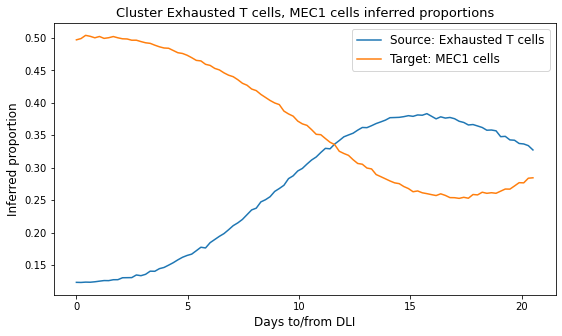

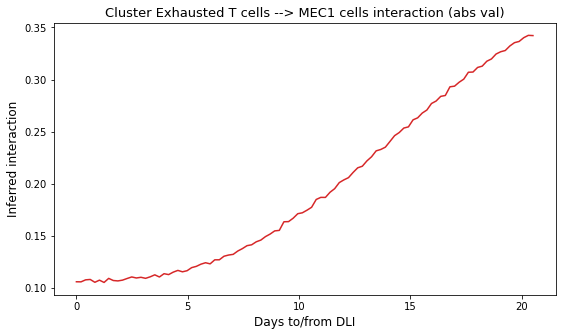

In [39]:
plt.figure(figsize=(9, 5))
plt.plot(X_test, y_preds[:, source_cluster_index], label=f'Source: {source_cluster}')
plt.plot(X_test, y_preds[:, target_cluster_index], label=f'Target: {target_cluster}')
plt.ylabel('Inferred proportion', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster}, {target_cluster} inferred proportions', fontsize=13)
plt.legend(loc='upper right', fontsize=12)

plt.figure(figsize=(9, 5))
plt.plot(X_test, np.abs(W[:, target_cluster_index, source_cluster_index]), color='tab:red')
plt.ylabel('Inferred interaction', fontsize=12)
plt.xlabel('Days to/from DLI', fontsize=12)
plt.title(f'Cluster {source_cluster} --> {target_cluster} interaction (abs val)', fontsize=13)

In [40]:
source_cluster_cells = gene_exp_df[metadata_df['cell_type'] == source_cluster]
source_cluster_cells

AGRN   TNFRSF4  TNFRSF14  TNFRSF25   TNFRSF9  \
CARC_T9_AAACCTGCATAGGATA -0.688850  1.993169 -0.688850 -2.302585 -0.100587   
CARC_T8_AAACCTGGTACAAGTA -2.302585  1.269377 -0.520723 -0.520723  0.084508   
CARC_T9_AAACCTGGTCAGATAA -1.559194  0.926922 -0.613926 -1.137527 -0.136808   
CARC_T8_AAACCTGGTCGGATCC -2.302585  1.261707 -0.043052 -2.302585 -2.302585   
CARC_T7_AAACGGGAGACGCTTT -2.302585  1.806950 -2.302585  0.261108  0.261108   
...                            ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCAGGTAAA -2.302585  0.275953 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585  1.030630 -0.993488 -0.993488 -0.093378   
CARC_T9_TTTGTCATCGGCTTGG -2.302585  0.680099 -0.744831 -0.744831 -0.744831   
CARC_T7_TTTGTCATCGTGGGAA -2.302585  1.396722 -2.302585  0.728015  0.728015   
CARC_T8_TTTGTCATCTTCATGT -2.302585  1.000449 -2.302585 -0.281202 -2.302585   

                          PIK3CD-AS1      CORT    DRAXIN    AGTRAP   TNFRSF8  \
CARC_T9_AAACCTGCATAGGATA   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_AAACCTGGTACAAGTA   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGGTCAGATAA   -2.302585 -2.302585 -2.302585 -1.559194 -2.302585   
CARC_T8_AAACCTGGTCGGATCC   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_AAACGGGAGACGCTTT   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
...                              ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCAGGTAAA   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   

                          ...       APP    IFNAR2    IL10RB    IFNAR1  \
CARC_T9_AAACCTGCATAGGATA  ... -2.302585 -2.302585 -2.302585 -0.688850   
CARC_T8_AAACCTGGTACAAGTA  ... -2.302585 -2.302585 -2.302585 -0.520723   
CARC_T9_AAACCTGGTCAGATAA  ... -1.559194 -2.302585 -2.302585 -1.559194   
CARC_T8_AAACCTGGTCGGATCC  ... -2.302585 -2.302585 -2.302585 -0.043052   
CARC_T7_AAACGGGAGACGCTTT  ... -2.302585 -2.302585 -2.302585 -2.302585   
...                       ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCAGGTAAA  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA  ... -0.993488 -2.302585 -2.302585 -0.993488   
CARC_T9_TTTGTCATCGGCTTGG  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT  ... -2.302585 -2.302585 -2.302585 -2.302585   

                            IFNGR2    ICOSLG     TRPM2     ITGB2   COL18A1  \
CARC_T9_AAACCTGCATAGGATA -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_AAACCTGGTACAAGTA -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_AAACCTGGTCAGATAA -2.302585 -2.302585 -2.302585 -1.559194 -2.302585   
CARC_T8_AAACCTGGTCGGATCC -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_AAACGGGAGACGCTTT -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
...                            ...       ...       ...       ...       ...   
CARC_T9_TTTGTCATCAGGTAAA -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGACGGAA -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCGGCTTGG -0.744831 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCATCGTGGGAA -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T8_TTTGTCATCTTCATGT -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   

                             S100B  
CARC_T9_AAACCTGCATAGGATA -2.302585  
CARC_T8_AAACCTGGTACAAGTA -2.302585  
CARC_T9_AAACCTGGTCAGATAA -2.302585  
CARC_T8_AAACCTGGTCGGATCC -2.302585  
CARC_T7_AAACGGGAGACGCTTT -2.302585  
...                            ...  
CARC_T9_TTTGTCATCAGGTAAA -2.302585  
CARC_T9_TTTGTCATCGACGG

In [41]:
target_cluster_cells = gene_exp_df[metadata_df['cell_type'] == target_cluster]
target_cluster_cells

AGRN   TNFRSF4  TNFRSF14  TNFRSF25   TNFRSF9  \
CARC_T9_AAACCTGAGCCATCGC -2.302585 -2.302585 -0.633307 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -2.302585 -0.990700 -0.442180 -2.302585 -0.990700   
CARC_T5_AAACCTGCAAATACAG -1.363917 -2.302585 -1.363917 -2.302585 -1.363917   
CARC_T6_AAACCTGCAAGAGTCG -2.302585 -2.302585 -0.901887 -2.302585 -2.302585   
CARC_T7_AAACCTGCAATGGTCT -2.302585  0.042249 -0.559356 -2.302585  0.042249   
...                            ...       ...       ...       ...       ...   
CARC_T4_TTTGTCAGTACTTAGC -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T5_TTTGTCAGTCGACTGC -2.302585 -2.302585 -0.243957 -2.302585 -2.302585   
CARC_T6_TTTGTCAGTCGCATAT -2.302585 -1.147719 -1.147719 -1.147719 -2.302585   
CARC_T7_TTTGTCAGTCGCATCG -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCATGTAGC -2.302585 -2.302585  0.317962 -2.302585 -2.302585   

                          PIK3CD-AS1      CORT    DRAXIN    AGTRAP   TNFRSF8  \
CARC_T9_AAACCTGAGCCATCGC   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG   -0.990700 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T5_AAACCTGCAAATACAG   -2.302585 -2.302585 -2.302585 -1.363917 -2.302585   
CARC_T6_AAACCTGCAAGAGTCG   -2.302585 -2.302585 -2.302585 -0.901887 -2.302585   
CARC_T7_AAACCTGCAATGGTCT   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
...                              ...       ...       ...       ...       ...   
CARC_T4_TTTGTCAGTACTTAGC   -2.302585 -2.302585 -2.302585 -0.574597 -2.302585   
CARC_T5_TTTGTCAGTCGACTGC   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T6_TTTGTCAGTCGCATAT   -2.302585 -2.302585 -2.302585 -1.147719 -2.302585   
CARC_T7_TTTGTCAGTCGCATCG   -2.302585 -2.302585 -2.302585 -2.302585  1.072729   
CARC_T9_TTTGTCATCATGTAGC   -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   

                          ...       APP    IFNAR2    IL10RB    IFNAR1  \
CARC_T9_AAACCTGAGCCATCGC  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T5_AAACCTGCAAATACAG  ... -1.363917 -1.363917 -1.363917 -1.363917   
CARC_T6_AAACCTGCAAGAGTCG  ... -2.302585 -0.901887 -2.302585 -2.302585   
CARC_T7_AAACCTGCAATGGTCT  ... -0.559356 -2.302585 -2.302585 -2.302585   
...                       ...       ...       ...       ...       ...   
CARC_T4_TTTGTCAGTACTTAGC  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T5_TTTGTCAGTCGACTGC  ... -0.243957 -2.302585 -2.302585 -0.243957   
CARC_T6_TTTGTCAGTCGCATAT  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCAGTCGCATCG  ... -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCATGTAGC  ... -2.302585 -2.302585 -2.302585  0.317962   

                            IFNGR2    ICOSLG     TRPM2     ITGB2   COL18A1  \
CARC_T9_AAACCTGAGCCATCGC -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T2_AAACCTGAGGTAGCTG -0.990700 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T5_AAACCTGCAAATACAG -0.888396 -2.302585 -2.302585 -1.363917 -2.302585   
CARC_T6_AAACCTGCAAGAGTCG -2.302585 -2.302585 -2.302585 -0.901887 -2.302585   
CARC_T7_AAACCTGCAATGGTCT -0.559356 -2.302585 -2.302585 -2.302585 -2.302585   
...                            ...       ...       ...       ...       ...   
CARC_T4_TTTGTCAGTACTTAGC -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T5_TTTGTCAGTCGACTGC -0.243957 -2.302585 -2.302585 -0.243957 -2.302585   
CARC_T6_TTTGTCAGTCGCATAT -0.626013 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T7_TTTGTCAGTCGCATCG -2.302585 -2.302585 -2.302585 -2.302585 -2.302585   
CARC_T9_TTTGTCATCATGTAGC  0.317962 -2.302585 -2.302585 -2.302585 -2.302585   

                             S100B  
CARC_T9_AAACCTGAGCCATCGC -2.302585  
CARC_T2_AAACCTGAGGTAGCTG -2.302585  
CARC_T5_AAACCTGCAAATACAG -2.302585  
CARC_T6_AAACCTGCAAGAGTCG -2.302585  
CARC_T7_AAACCTGCAATGGTCT -2.302585  
...                            ...  
CARC_T4_TTTGTCAGTACTTAGC -2.302585  
CARC_T5_TTTGTCAGTCGACT

Filter down to differentially-expressed RL genes per cluster

In [42]:
source_cluster_degs = cluster_to_degs[source_cluster]
target_cluster_degs = cluster_to_degs[target_cluster]

In [43]:
min_exp_threshold = -2
sliding_window_length = 2

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_receptor_corrs_with_interaction = []
for index, rl_pair in tqdm_notebook(list(rl_pairs.iterrows())):
    ligand_gene = rl_pair['source_genesymbol']
    receptor_gene = rl_pair['target_genesymbol']
    # Filter to differentially-expressed RL genes
    if (ligand_gene not in source_cluster_degs or receptor_gene not in target_cluster_degs):
        continue
    # Model for ligand gene expression
    ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
    ligand_timestamps = metadata_df.loc[ligand_gene_exp.index, 'timestamp']
    timestamps = sorted(ligand_timestamps.unique())
    if len(timestamps) < sliding_window_length: continue
    sliding_window_mean_ligand_gene_exp = pd.Series({
        days: ligand_gene_exp[ligand_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(timestamps)
    })
    ligand_closest_Xs_to_timestamps = np.array([], dtype='int')
    for days in sliding_window_mean_ligand_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        ligand_closest_Xs_to_timestamps = np.append(ligand_closest_Xs_to_timestamps, closest_X)
    # Model for receptor gene expression
    receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
    receptor_timestamps = metadata_df.loc[receptor_gene_exp.index, 'timestamp']
    timestamps = sorted(receptor_timestamps.unique())
    if len(timestamps) < sliding_window_length: continue
    sliding_window_mean_receptor_gene_exp = pd.Series({
        days: receptor_gene_exp[receptor_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
        for i, days in enumerate(timestamps)
    })
    receptor_closest_Xs_to_timestamps = np.array([], dtype='int')
    for days in sliding_window_mean_receptor_gene_exp.index:
        closest_X = np.argmin(np.abs(X_test - days))
        receptor_closest_Xs_to_timestamps = np.append(receptor_closest_Xs_to_timestamps, closest_X)
    # Correlations b/w ligand/receptor gene expression and inferred interaction
    ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps][sliding_window_length-1:])
    receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                    source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_timestamps][sliding_window_length-1:])
    ligand_receptor_corrs_with_interaction.append({
        'Ligand': ligand_gene,
        'Ligand-interaction correlation': ligand_interaction_corr[0, 1],
        'Ligand DEG pval': source_cluster_degs[ligand_gene],
        'Receptor': receptor_gene,
        'Receptor-interaction correlation': receptor_interaction_corr[0, 1],
        'Receptor DEG pval': target_cluster_degs[receptor_gene],
        'Avg ligand/receptor-interaction correlation': (ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2
    })
    

  0%|          | 0/1587 [00:00<?, ?it/s]

In [44]:
ligand_receptor_corrs_with_interaction_df = pd.DataFrame(ligand_receptor_corrs_with_interaction)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.sort_values('Avg ligand/receptor-interaction correlation', ascending=False)
ligand_receptor_corrs_with_interaction_df = ligand_receptor_corrs_with_interaction_df.reset_index(drop=True)
ligand_receptor_corrs_with_interaction_df.head(25)

Ligand  Ligand-interaction correlation  Ligand DEG pval Receptor  \
0     CALM2                        0.731575     0.000000e+00    KCNQ5   
1      YBX1                        0.782091     0.000000e+00   NOTCH1   
2       MIF                        0.780191     8.796922e-12    CXCR4   
3     CALM2                        0.731575     0.000000e+00     INSR   
4       BSG                        0.562697     9.017826e-18  SLC16A1   
5       UBB                        0.672945     0.000000e+00   TGFBR1   
6     FABP5                        0.655176     0.000000e+00     RXRA   
7      CD47                        0.536514     0.000000e+00    SIRPA   
8     LMAN1                        0.707781     0.000000e+00    MCFD2   
9       UBB                        0.672945     0.000000e+00     LDLR   
10      MIF                        0.780191     8.796922e-12     CD74   
11    STUB1                        0.496966     2.000170e-64   DNAJA3   
12  HSP90B1                        0.363488     1.834520e-14     TLR1   
13  HSP90B1                        0.363488     1.834520e-14     TLR7   
14    HMGB1                        0.372692    6.913954e-121    CXCR4   
15     HRAS                        0.292170    1.155395e-238     CAV1   
16     HRAS                        0.292170    1.155395e-238     INSR   
17    HSPA8                        0.282358     0.000000e+00     LDLR   
18      CD4                        0.170012     8.360933e-72    CXCR4   
19     GZMB                        0.234648     0.000000e+00   PGRMC1   
20    CALM1                       -0.124587    2.244222e-268      FAS   
21     DLL3                       -0.016954     1.674766e-91   NOTCH1   
22     CD99                       -0.037421     0.000000e+00    PILRB   
23    FAM3C                        0.006296     7.491235e-15    LAMP1   
24      UBC                       -0.065787    1.015647e-252   TGFBR1   

    Receptor-interaction correlation  Receptor DEG pval  \
0                           0.874403       4.365909e-03   
1                           0.815210       2.599814e-25   
2                           0.801068       1.885555e-12   
3                           0.829348       2.215539e-06   
4                           0.939685       1.266680e-32   
5                           0.820795       7.896215e-04   
6                           0.828522       0.000000e+00   
7                           0.938029       1.312650e-06   
8                           0.718934       6.124279e-15   
9                           0.744599       3.618004e-24   
10                          0.591643       0.000000e+00   
11                          0.790045       6.375156e-99   
12                          0.866604       3.018517e-08   
13                          0.810911       7.850780e-13   
14                          0.801068       1.885555e-12   
15                          0.848104       0.000000e+00   
16                          0.829348       2.215539e-06   
17                          0.744599       3.618004e-24   
18                          0.801068       1.885555e-12   
19                          0.587026       7.023374e-03   
20                          0.938802       8.193024e-19   
21                          0.815210       2.599814e-25   
22                          0.829020       4.495285e-10   
23                          0.757204      2.009705e-124   
24                          0.820795       7.896215e-04   

    Avg ligand/receptor-interaction correlation  
0                                      0.802989  
1                                      0.798651  
2                                      0.790630  
3                                      0.780462  
4                                      0.751191  
5                                      0.746870  
6                                      0.741849  
7                                      0.737272  
8                                      0.713358  
9                                      0.708772  
10                   

Sliding window mean of ligand and receptor expression at DLI time points

In [45]:
ligand_gene = 'IL2RA'
receptor_gene = 'CD19'

min_exp_threshold = -2
sliding_window_length = 2

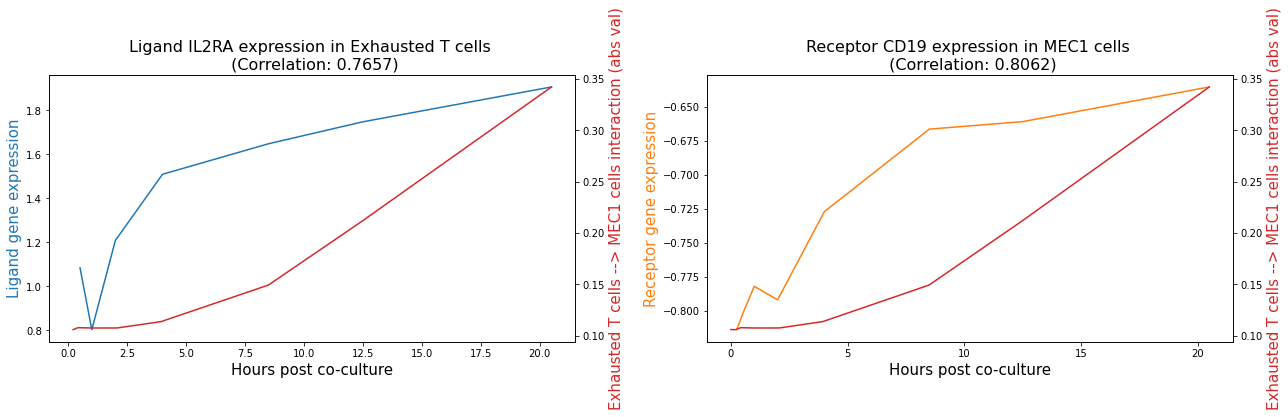

In [46]:
min_exp_threshold = -2

source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])


ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_timestamps = metadata_df.loc[ligand_gene_exp.index, 'timestamp']
timestamps = sorted(ligand_timestamps.unique())
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(timestamps)
})
ligand_closest_Xs_to_timestamps = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_timestamps = np.append(ligand_closest_Xs_to_timestamps, closest_X)    
ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                            source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps][sliding_window_length-1:])

receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_timestamps = metadata_df.loc[receptor_gene_exp.index, 'timestamp']
timestamps = sorted(receptor_timestamps.unique())
sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(timestamps)
})
receptor_closest_Xs_to_timestamps = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_timestamps = np.append(receptor_closest_Xs_to_timestamps, closest_X)
receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_timestamps][sliding_window_length-1:])


plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
ax2 = ax1.twinx()
# ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
         sliding_window_mean_ligand_gene_exp, 
         color='tab:blue')
ax1.set_ylabel('Ligand gene expression', fontsize=15, color='tab:blue')
ax2.plot(X_test[ligand_closest_Xs_to_timestamps], 
         source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps], color='tab:red')
ax2.set_ylabel(f'{source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Hours post co-culture', fontsize=15)
plt.title(f'Ligand {ligand_gene} expression in {source_cluster} \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
          fontsize=16)

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
# ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
         sliding_window_mean_receptor_gene_exp, 
         color='tab:orange')
ax1.set_ylabel('Receptor gene expression', fontsize=15, color='tab:orange')
ax2.plot(X_test[receptor_closest_Xs_to_timestamps], 
         source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_timestamps], color='tab:red')
ax2.set_ylabel(f'{source_cluster} --> {target_cluster} interaction (abs val)',
               fontsize=15, color='tab:red')
ax1.set_xlabel('Hours post co-culture', fontsize=15)
plt.title(f'Receptor {receptor_gene} expression in {target_cluster} \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
          fontsize=16)
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

[Text(0.5, 0, '0.25'),
 Text(1.5, 0, '0.5'),
 Text(2.5, 0, '1.0'),
 Text(3.5, 0, '2.0'),
 Text(4.5, 0, '4.0'),
 Text(5.5, 0, '8.5'),
 Text(6.5, 0, '12.5'),
 Text(7.5, 0, '20.5')]

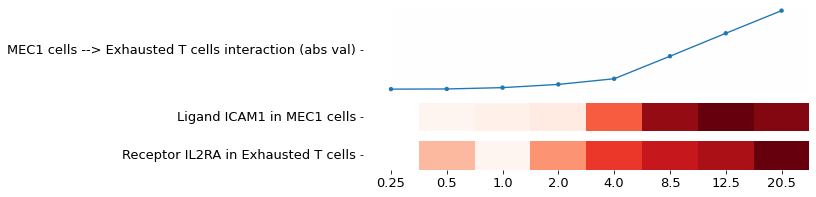

In [21]:
source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
ligand_timestamps = metadata_df.loc[ligand_gene_exp.index, 'timestamp']
receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
receptor_timestamps = metadata_df.loc[receptor_gene_exp.index, 'timestamp']

timestamps = sorted(set(ligand_timestamps.unique()).intersection(receptor_timestamps.unique()))
sliding_window_mean_ligand_gene_exp = pd.Series({
    days: ligand_gene_exp[ligand_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(timestamps)
})
ligand_closest_Xs_to_timestamps = np.array([], dtype='int')
for days in sliding_window_mean_ligand_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    ligand_closest_Xs_to_timestamps = np.append(ligand_closest_Xs_to_timestamps, closest_X)

sliding_window_mean_receptor_gene_exp = pd.Series({
    days: receptor_gene_exp[receptor_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
    for i, days in enumerate(timestamps)
})
receptor_closest_Xs_to_timestamps = np.array([], dtype='int')
for days in sliding_window_mean_receptor_gene_exp.index:
    closest_X = np.argmin(np.abs(X_test - days))
    receptor_closest_Xs_to_timestamps = np.append(receptor_closest_Xs_to_timestamps, closest_X)

rl_expression = pd.DataFrame(np.vstack([sliding_window_mean_ligand_gene_exp, 
                                        sliding_window_mean_receptor_gene_exp]), 
                             columns=timestamps)
rl_expression.index = [f'Ligand {ligand_gene} in {source_cluster}', 
                       f'Receptor {receptor_gene} in {target_cluster}']

plt.figure(figsize=(8, 3))
gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1]) 
plt.subplot(gs[0])
g = sns.heatmap([np.zeros_like(source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps])], 
                yticklabels=[f'{source_cluster} --> {target_cluster} interaction (abs val)'],
                cmap='bwr', vmin=-1, center=0, vmax=1, cbar=False)
ax2 = plt.twinx()
sns.pointplot(x=sliding_window_mean_ligand_gene_exp.index,
             y=source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps], 
             ax=ax2, scale=0.5)
plt.axis('off')
g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
g.set_xticklabels([], size = 13)
g.set_xticks([])
plt.subplot(gs[1])
g = sns.heatmap(pd.DataFrame(rl_expression.iloc[0]).T, cmap='Reds', cbar=False)
g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
g.set_xticklabels([], size = 13)
g.set_xticks([])
plt.subplot(gs[2])
g = sns.heatmap(pd.DataFrame(rl_expression.iloc[1]).T, cmap='Reds', cbar=False)
g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
g.set_xticklabels(g.get_xticklabels(), size = 13, rotation=0)

In [22]:
min_exp_threshold = -2
sliding_window_length = 2

for source_cluster in tqdm_notebook(cell_types):
    for target_cluster in cell_types:
        if source_cluster not in cluster_to_degs or target_cluster not in cluster_to_degs: continue
        source_target_rl_corrs_with_interaction = []
        print(source_cluster, target_cluster)
        
        source_cluster_index = list(cell_types).index(source_cluster)
        source_cluster_cells = gene_exp_df[metadata_df['cell_type'] == source_cluster]
        source_cluster_degs = cluster_to_degs[source_cluster]
        
        target_cluster_index = list(cell_types).index(target_cluster)
        target_cluster_cells = gene_exp_df[metadata_df['cell_type'] == target_cluster]
        target_cluster_degs = cluster_to_degs[target_cluster]
        
        source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])

        for index, rl_pair in list(rl_pairs.iterrows()):
            ligand_gene = rl_pair['source_genesymbol']
            receptor_gene = rl_pair['target_genesymbol']
            # Filter to differentially-expressed RL genes
            if (ligand_gene not in source_cluster_degs or receptor_gene not in target_cluster_degs):
                continue
            # Model for ligand gene expression
            ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
            ligand_timestamps = metadata_df.loc[ligand_gene_exp.index, 'timestamp']
            timestamps = sorted(ligand_timestamps.unique())
            if len(timestamps) < sliding_window_length: continue
            sliding_window_mean_ligand_gene_exp = pd.Series({
                days: ligand_gene_exp[ligand_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
                for i, days in enumerate(timestamps)
            })
            ligand_closest_Xs_to_timestamps = np.array([], dtype='int')
            for days in sliding_window_mean_ligand_gene_exp.index:
                closest_X = np.argmin(np.abs(X_test - days))
                ligand_closest_Xs_to_timestamps = np.append(ligand_closest_Xs_to_timestamps, closest_X)
            # Model for receptor gene expression
            receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
            receptor_timestamps = metadata_df.loc[receptor_gene_exp.index, 'timestamp']
            timestamps = sorted(receptor_timestamps.unique())
            if len(timestamps) < sliding_window_length: continue
            sliding_window_mean_receptor_gene_exp = pd.Series({
                days: receptor_gene_exp[receptor_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
                for i, days in enumerate(timestamps)
            })
            receptor_closest_Xs_to_timestamps = np.array([], dtype='int')
            for days in sliding_window_mean_receptor_gene_exp.index:
                closest_X = np.argmin(np.abs(X_test - days))
                receptor_closest_Xs_to_timestamps = np.append(receptor_closest_Xs_to_timestamps, closest_X)
            # Correlations b/w ligand/receptor gene expression and inferred interaction
            ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                        source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps][sliding_window_length-1:])
            receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                            source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_timestamps][sliding_window_length-1:])
            
            source_target_rl_corrs_with_interaction.append({
                    'Source cluster': source_cluster,
                    'Target cluster': target_cluster,
                    'Ligand': ligand_gene,
                    'Ligand-interaction correlation': ligand_interaction_corr[0, 1],
                    'Ligand DEG pval': source_cluster_degs[ligand_gene],
                    'Receptor': receptor_gene,
                    'Receptor-interaction correlation': receptor_interaction_corr[0, 1],
                    'Receptor DEG pval': target_cluster_degs[receptor_gene],
                    'Avg ligand/receptor-interaction correlation': (ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2
                })
            source_target_rl_corrs_with_interaction_df = pd.DataFrame(source_target_rl_corrs_with_interaction)
            if source_target_rl_corrs_with_interaction_df.shape[0] == 0: continue
            source_target_rl_corrs_with_interaction_df = pd.merge(source_target_rl_corrs_with_interaction_df, 
                                                                  rl_pairs[['source_genesymbol', 'target_genesymbol', 'n_references', 'n_sources']], 
                                                                  how='left', left_on=['Ligand', 'Receptor'], 
                                                                  right_on=['source_genesymbol', 'target_genesymbol'])
            source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.drop(columns=['source_genesymbol', 'target_genesymbol', 
                                                                                                                  'Source cluster', 'Target cluster'])
            source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.sort_values('Avg ligand/receptor-interaction correlation', ascending=False)
            source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.reset_index(drop=True)
            source_target_rl_corrs_with_interaction_df = source_target_rl_corrs_with_interaction_df.head(30)
            source_target_rl_corrs_with_interaction_df.to_csv(f'figures/CAR-T//DIISCO_top_RL_pairs/{source_cluster} --> {target_cluster}.csv',
                                                                index=False)


  0%|          | 0/4 [00:00<?, ?it/s]

MEC1 cells MEC1 cells
MEC1 cells Other CD8+ T cells
MEC1 cells Activated T cells
MEC1 cells Exhausted T cells
Other CD8+ T cells MEC1 cells
Other CD8+ T cells Other CD8+ T cells
Other CD8+ T cells Activated T cells
Other CD8+ T cells Exhausted T cells
Activated T cells MEC1 cells
Activated T cells Other CD8+ T cells
Activated T cells Activated T cells
Activated T cells Exhausted T cells
Exhausted T cells MEC1 cells
Exhausted T cells Other CD8+ T cells
Exhausted T cells Activated T cells
Exhausted T cells Exhausted T cells


  0%|          | 0/4 [00:00<?, ?it/s]

MEC1 cells --> Other CD8+ T cells
No predicted interactions

MEC1 cells --> Activated T cells
Ligand: COL9A3
Receptor: CD44
Ligand-interaction correlation: 0.7033
Receptor-interaction correlation: 0.4272
Avg ligand/receptor-interaction correlation: 0.5653


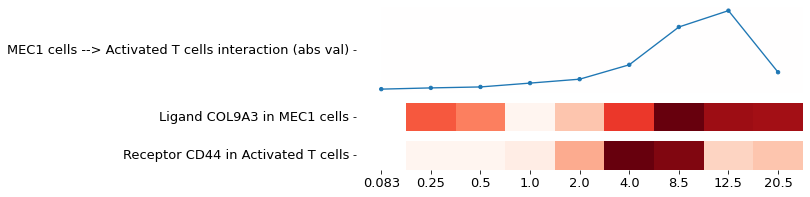

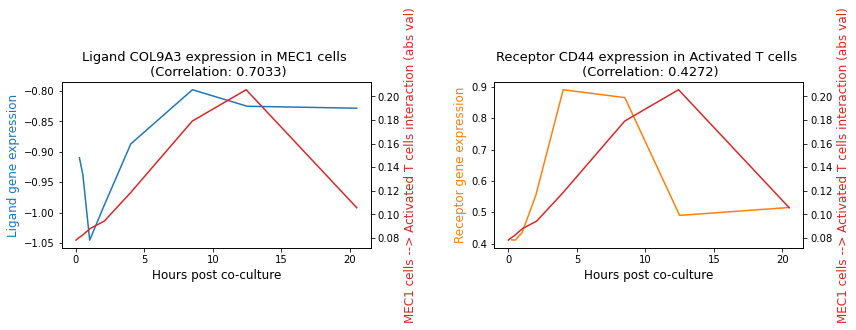



Ligand: CLEC2B
Receptor: KLRB1
Ligand-interaction correlation: 0.7720
Receptor-interaction correlation: 0.2376
Avg ligand/receptor-interaction correlation: 0.5048


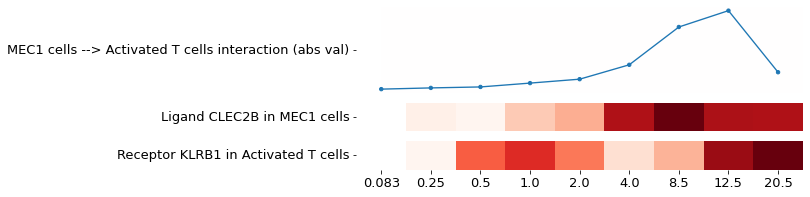

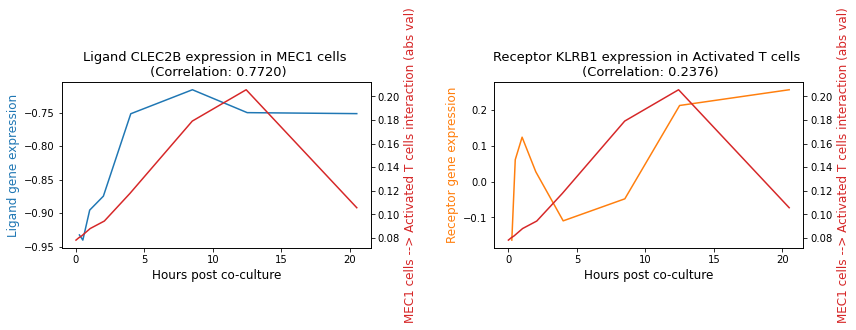



Ligand: FAM3C
Receptor: CLEC2D
Ligand-interaction correlation: 0.7193
Receptor-interaction correlation: 0.1646
Avg ligand/receptor-interaction correlation: 0.4420


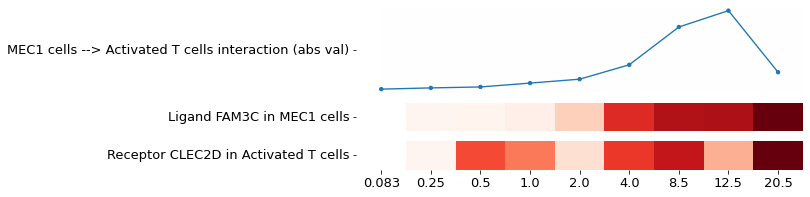

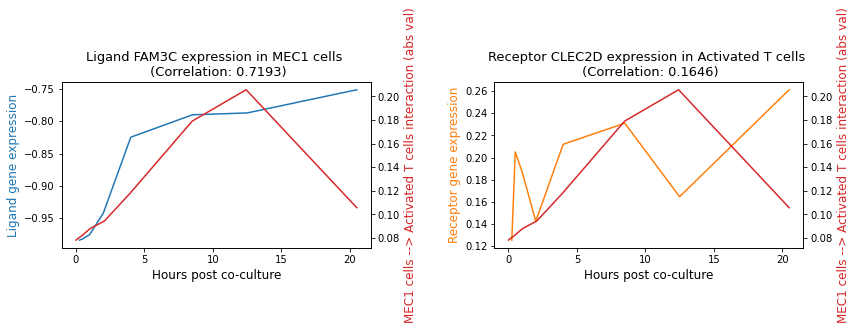



Ligand: LGALS9
Receptor: CD44
Ligand-interaction correlation: 0.5490
Receptor-interaction correlation: 0.4272
Avg ligand/receptor-interaction correlation: 0.4881


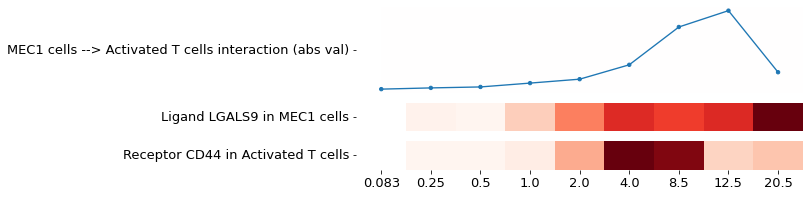

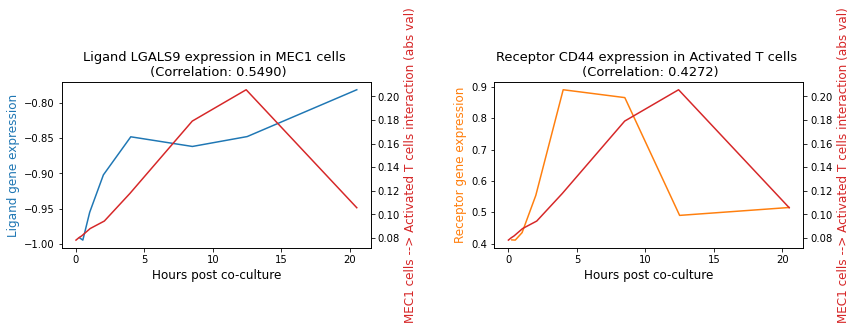



Ligand: ICAM1
Receptor: EZR
Ligand-interaction correlation: 0.8171
Receptor-interaction correlation: -0.083
Avg ligand/receptor-interaction correlation: 0.3668


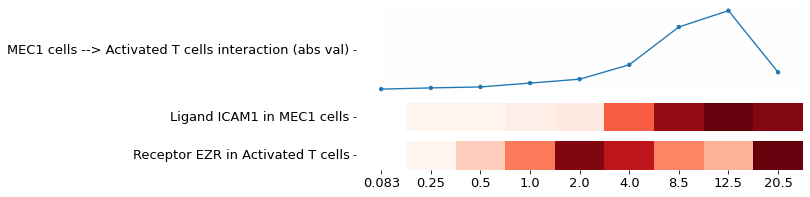

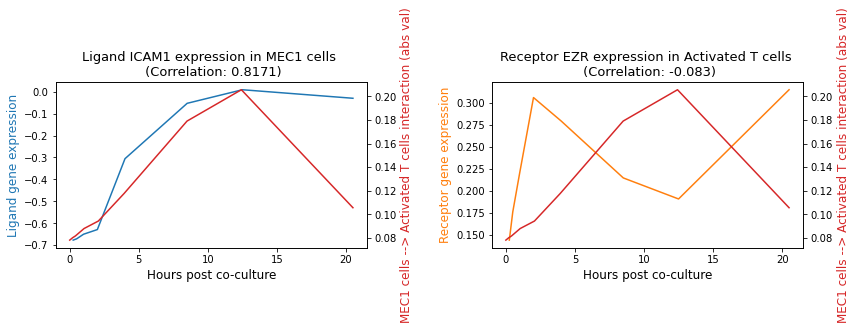



Ligand: ADAM10
Receptor: CD44
Ligand-interaction correlation: 0.5189
Receptor-interaction correlation: 0.4272
Avg ligand/receptor-interaction correlation: 0.4731


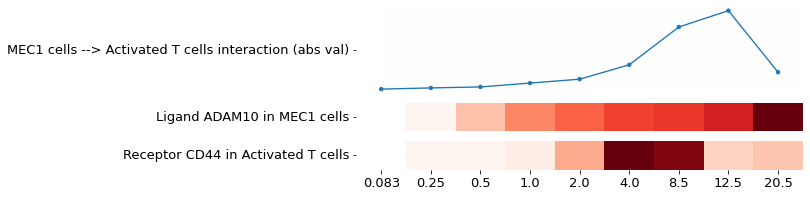

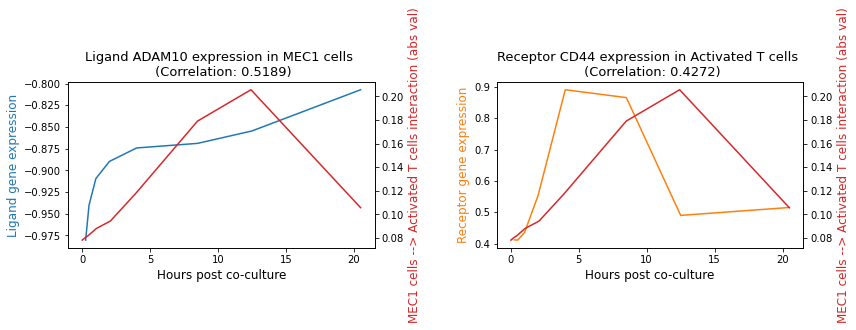



Ligand: HLA-DRA
Receptor: CD53
Ligand-interaction correlation: 0.8912
Receptor-interaction correlation: -0.150
Avg ligand/receptor-interaction correlation: 0.3701


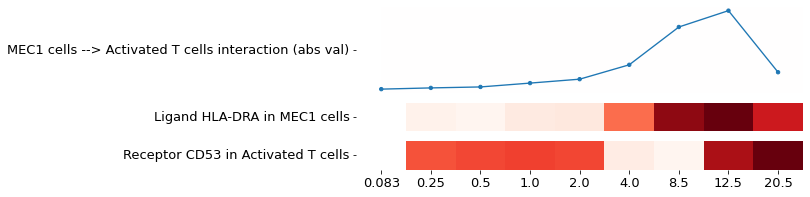

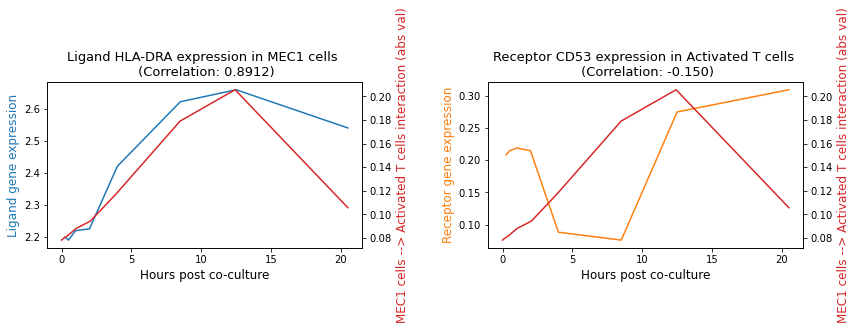



Ligand: HGF
Receptor: CD44
Ligand-interaction correlation: 0.4371
Receptor-interaction correlation: 0.4272
Avg ligand/receptor-interaction correlation: 0.4322


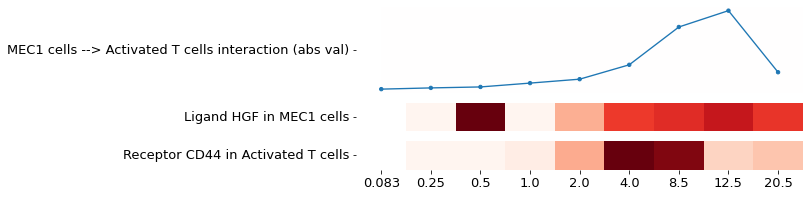

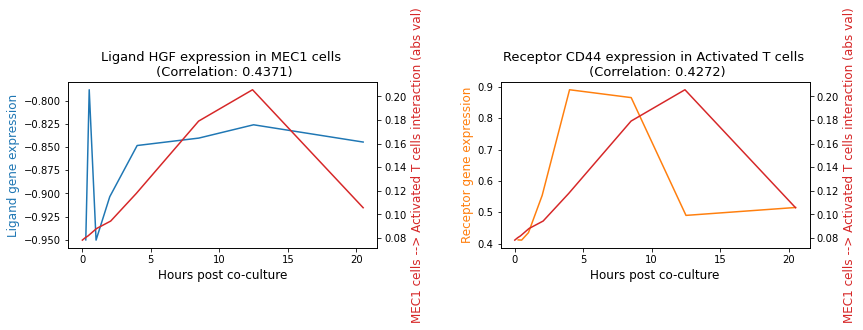



Ligand: HLA-DRB1
Receptor: CD53
Ligand-interaction correlation: 0.8760
Receptor-interaction correlation: -0.150
Avg ligand/receptor-interaction correlation: 0.3626


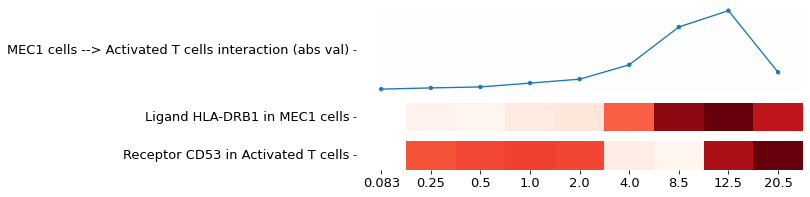

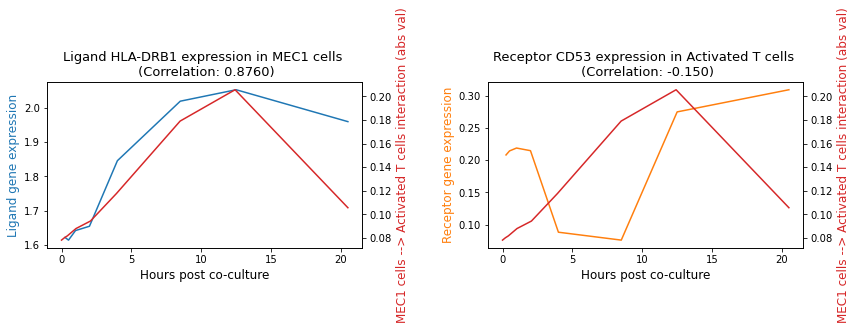



Ligand: ICAM1
Receptor: MSN
Ligand-interaction correlation: 0.8171
Receptor-interaction correlation: -0.289
Avg ligand/receptor-interaction correlation: 0.2637


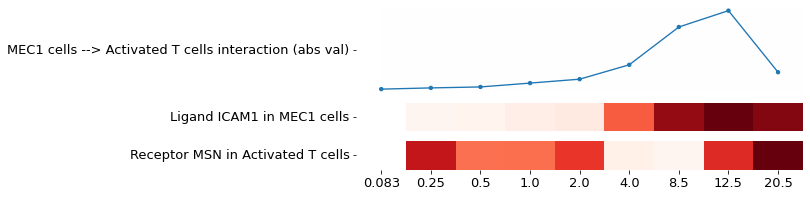

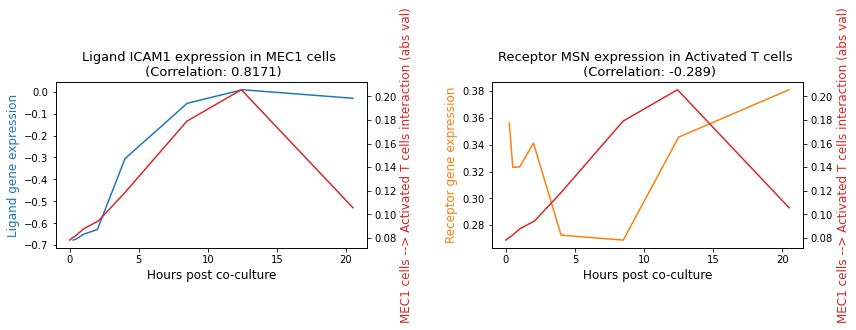



MEC1 cells --> Exhausted T cells
Ligand: ICAM1
Receptor: IL2RA
Ligand-interaction correlation: 0.8723
Receptor-interaction correlation: 0.8737
Avg ligand/receptor-interaction correlation: 0.8730


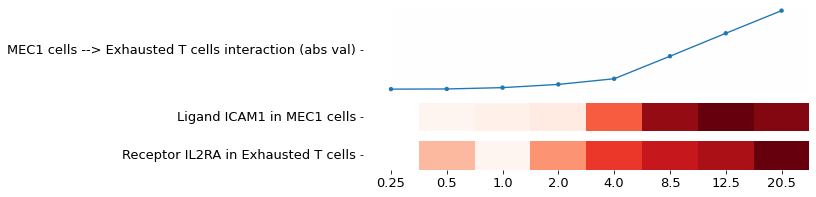

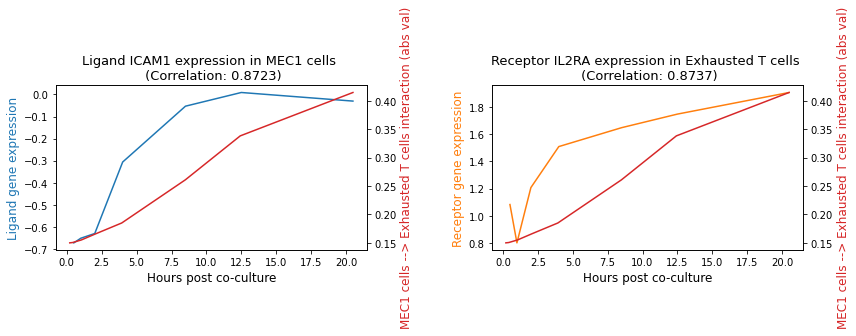



Ligand: AGTRAP
Receptor: RACK1
Ligand-interaction correlation: 0.9692
Receptor-interaction correlation: 0.7750
Avg ligand/receptor-interaction correlation: 0.8721


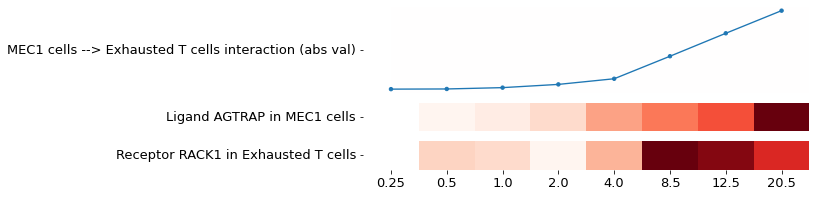

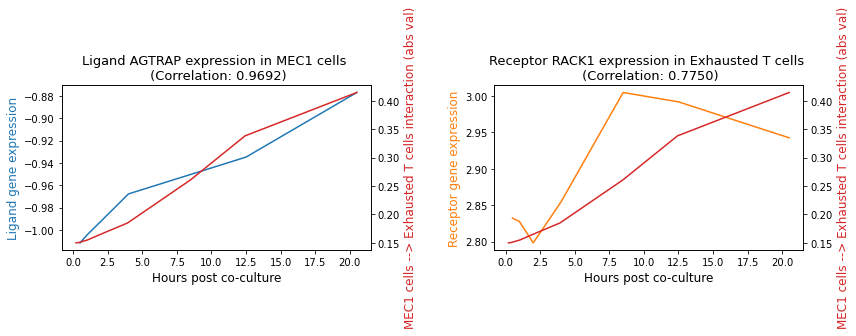



Ligand: TOR2A
Receptor: ATP5F1B
Ligand-interaction correlation: 0.9177
Receptor-interaction correlation: 0.7861
Avg ligand/receptor-interaction correlation: 0.8519


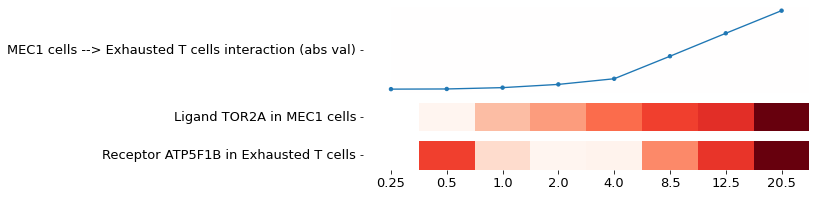

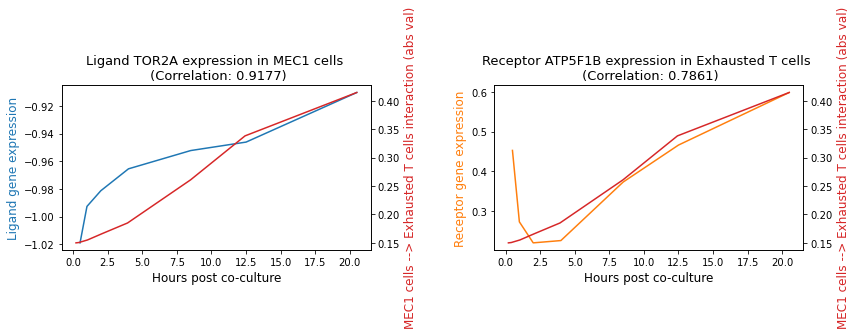



Ligand: SIRPA
Receptor: CD47
Ligand-interaction correlation: 0.9435
Receptor-interaction correlation: 0.7118
Avg ligand/receptor-interaction correlation: 0.8276


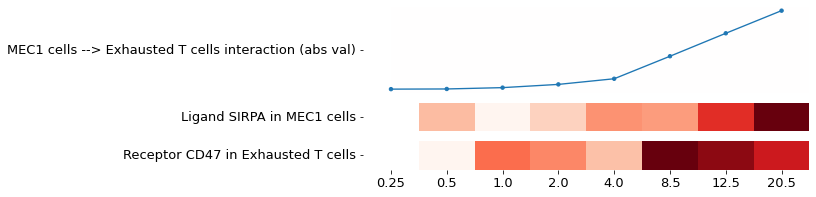

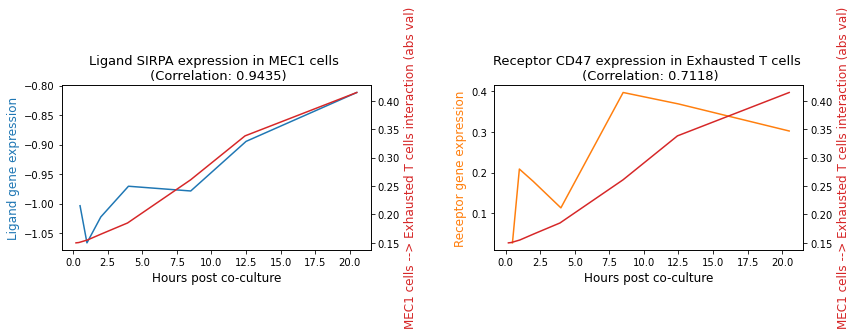



Ligand: LGALS9
Receptor: CD47
Ligand-interaction correlation: 0.8308
Receptor-interaction correlation: 0.7118
Avg ligand/receptor-interaction correlation: 0.7713


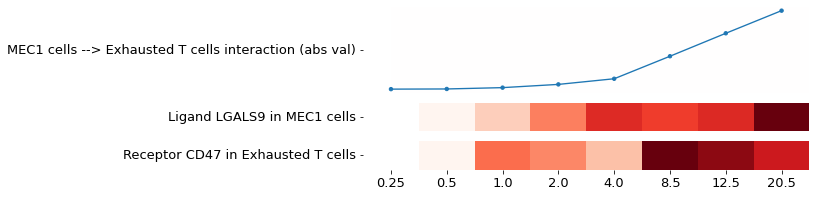

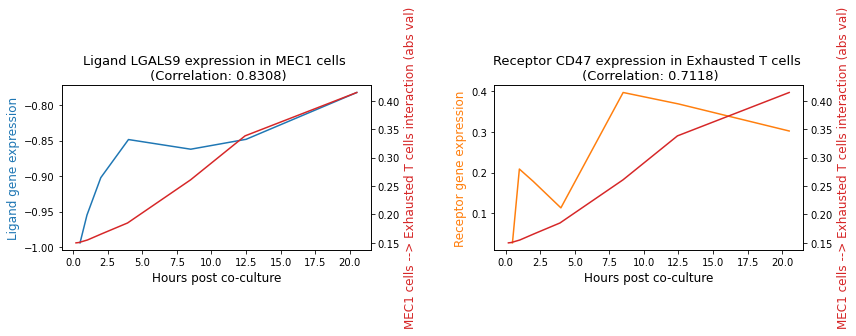



Ligand: IL15
Receptor: IL2RA
Ligand-interaction correlation: 0.6784
Receptor-interaction correlation: 0.8737
Avg ligand/receptor-interaction correlation: 0.7761


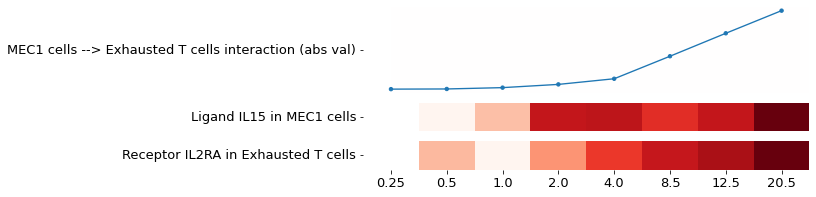

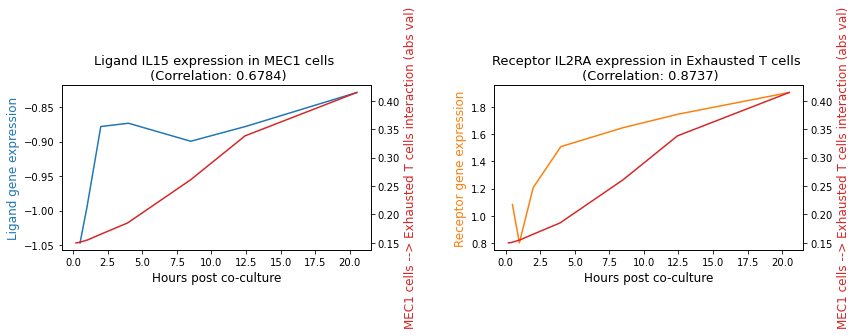



Ligand: HLA-DMA
Receptor: CD4
Ligand-interaction correlation: 0.8217
Receptor-interaction correlation: 0.4226
Avg ligand/receptor-interaction correlation: 0.6222


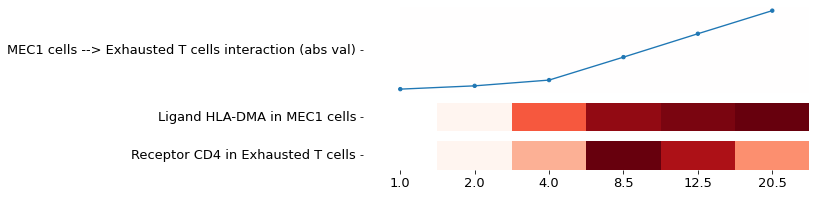

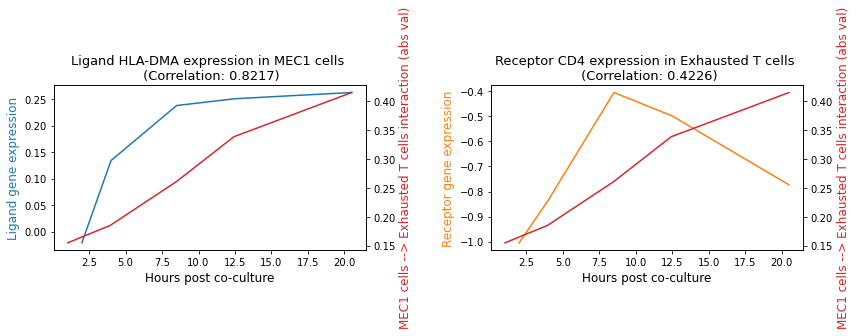



Ligand: HLA-DOA
Receptor: CD4
Ligand-interaction correlation: 0.8174
Receptor-interaction correlation: 0.4226
Avg ligand/receptor-interaction correlation: 0.6200


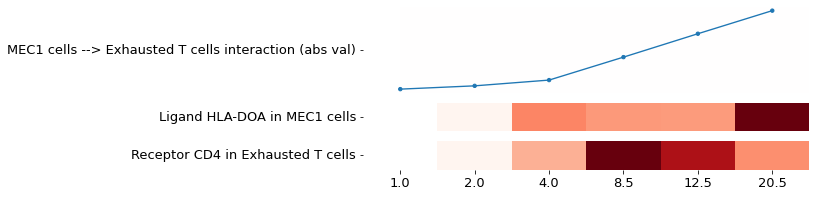

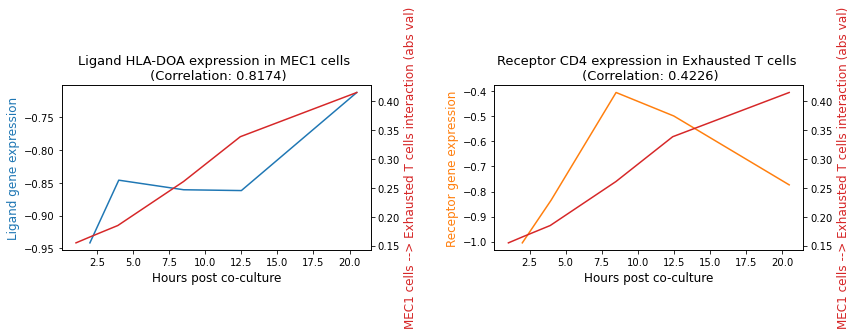



Ligand: CD59
Receptor: CD2
Ligand-interaction correlation: 0.9650
Receptor-interaction correlation: 0.3409
Avg ligand/receptor-interaction correlation: 0.6530


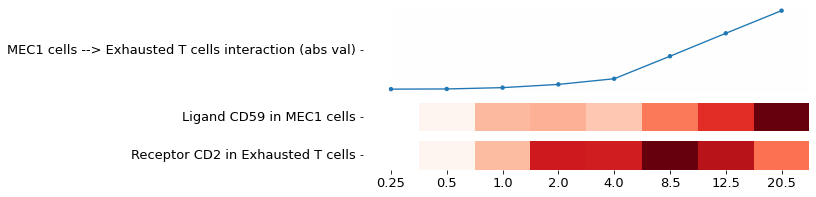

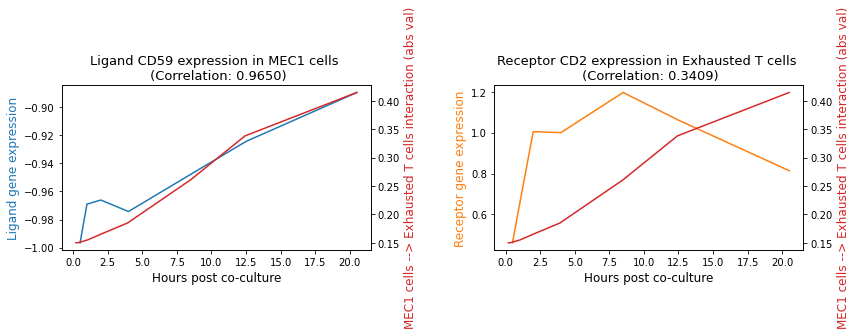



Ligand: IL16
Receptor: CD4
Ligand-interaction correlation: 0.8922
Receptor-interaction correlation: 0.4226
Avg ligand/receptor-interaction correlation: 0.6574


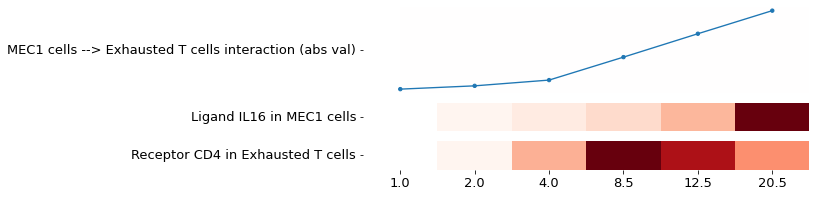

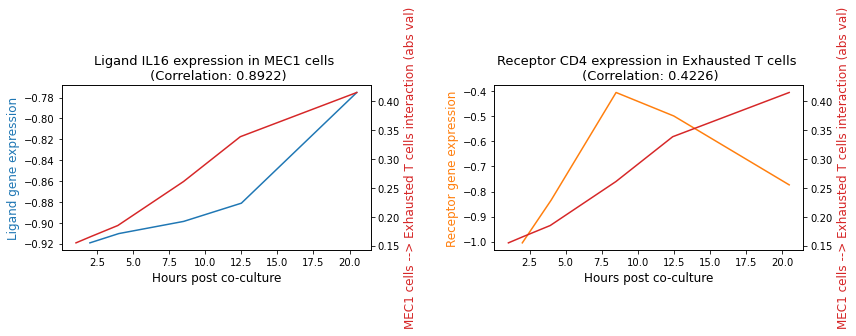



Other CD8+ T cells --> MEC1 cells
Ligand: HLA-B
Receptor: CANX
Ligand-interaction correlation: 0.6492
Receptor-interaction correlation: 0.8669
Avg ligand/receptor-interaction correlation: 0.7581


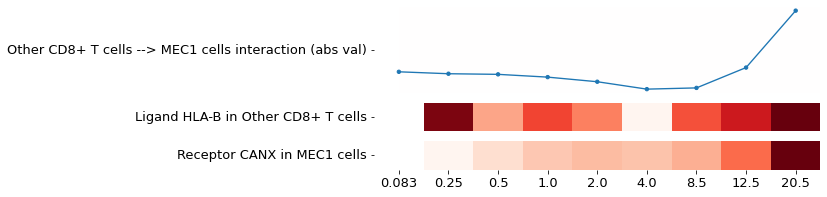

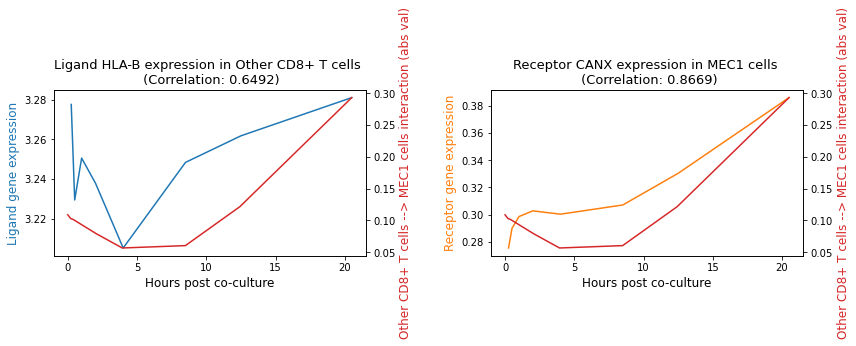



Ligand: HLA-B
Receptor: LILRB1
Ligand-interaction correlation: 0.6492
Receptor-interaction correlation: 0.8127
Avg ligand/receptor-interaction correlation: 0.7310


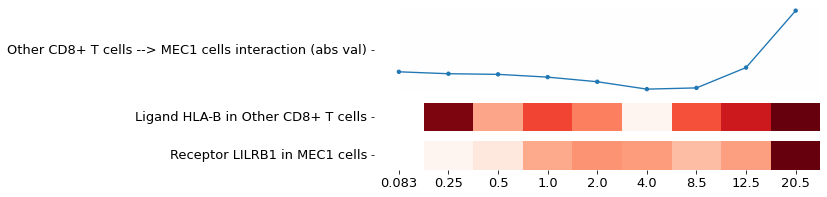

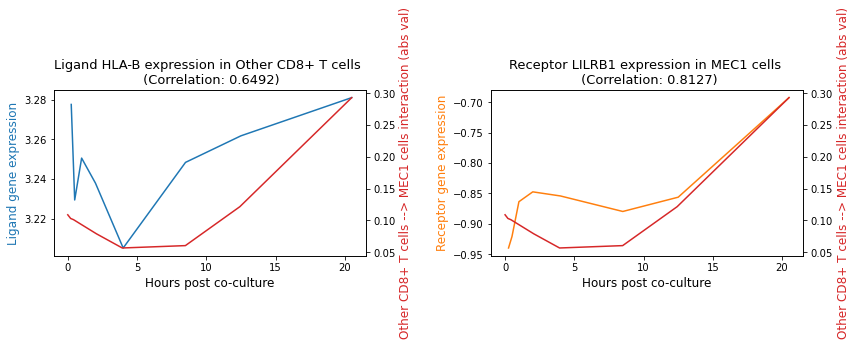



Ligand: HLA-A
Receptor: LILRB1
Ligand-interaction correlation: 0.3968
Receptor-interaction correlation: 0.8127
Avg ligand/receptor-interaction correlation: 0.6047


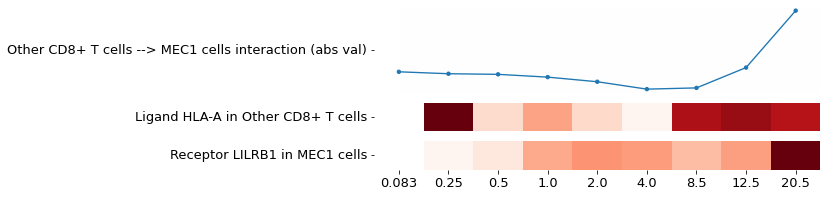

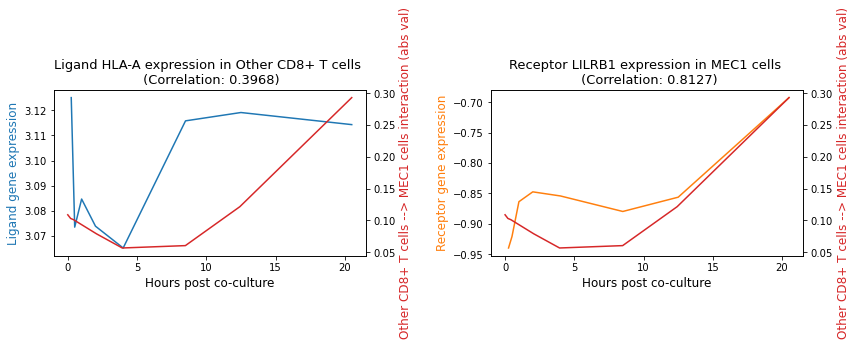



Ligand: ACTR2
Receptor: LDLR
Ligand-interaction correlation: 0.7027
Receptor-interaction correlation: 0.4938
Avg ligand/receptor-interaction correlation: 0.5982


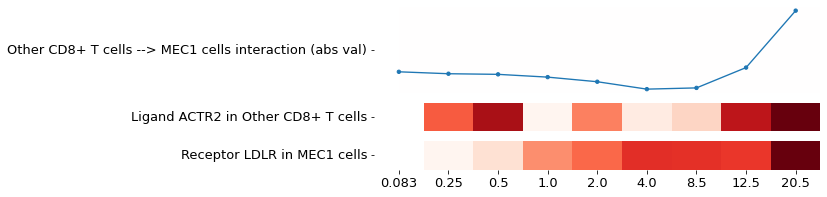

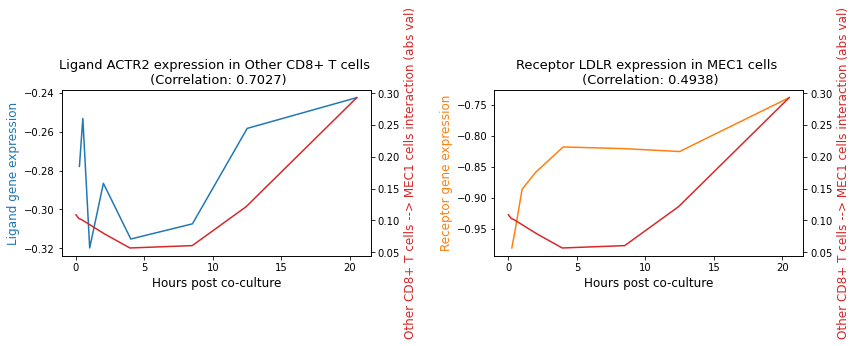



Ligand: PIK3R1
Receptor: EPN1
Ligand-interaction correlation: 0.4160
Receptor-interaction correlation: 0.7478
Avg ligand/receptor-interaction correlation: 0.5819


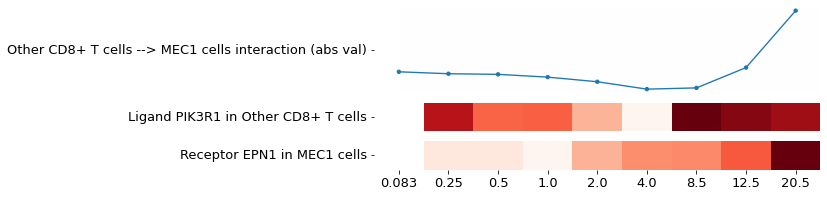

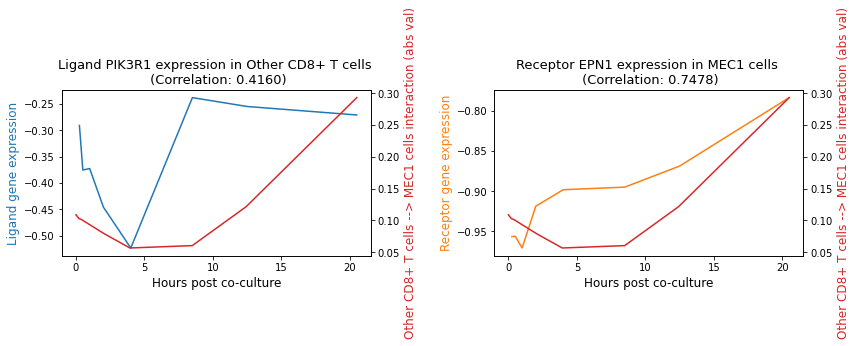



Ligand: CD99
Receptor: PILRB
Ligand-interaction correlation: 0.5070
Receptor-interaction correlation: 0.6535
Avg ligand/receptor-interaction correlation: 0.5802


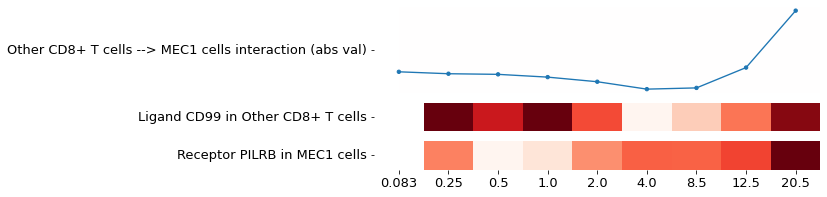

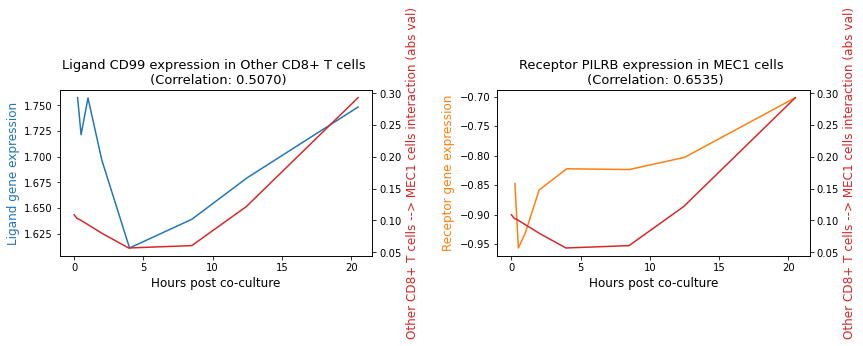



Ligand: UBC
Receptor: TGFBR1
Ligand-interaction correlation: 0.5556
Receptor-interaction correlation: 0.5858
Avg ligand/receptor-interaction correlation: 0.5707


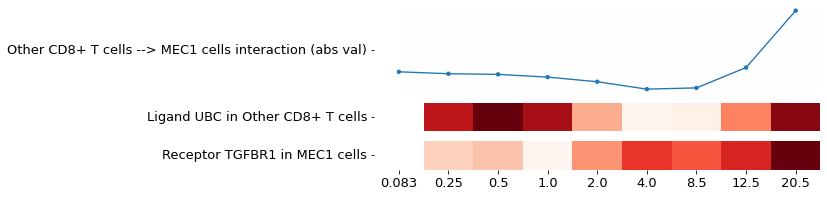

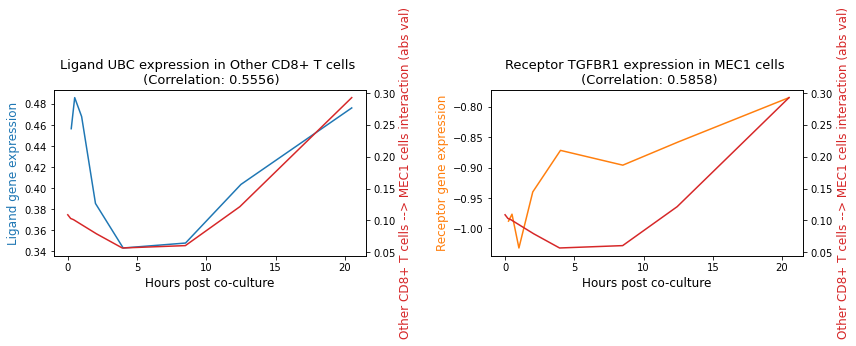



Ligand: CD99
Receptor: PILRA
Ligand-interaction correlation: 0.5070
Receptor-interaction correlation: 0.5515
Avg ligand/receptor-interaction correlation: 0.5292


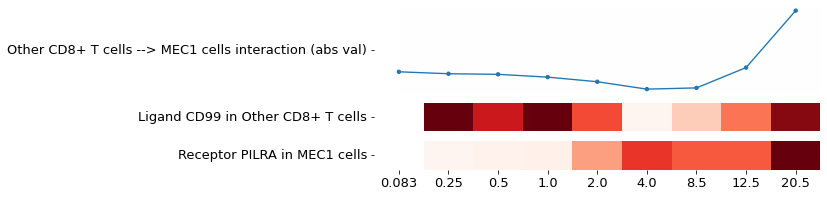

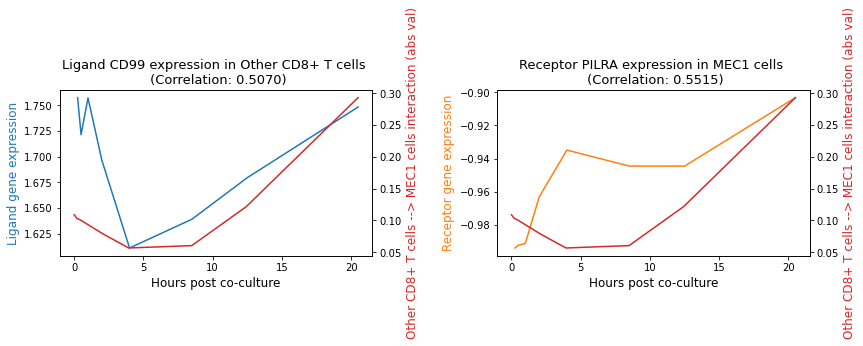



Ligand: UBC
Receptor: LDLR
Ligand-interaction correlation: 0.5556
Receptor-interaction correlation: 0.4938
Avg ligand/receptor-interaction correlation: 0.5247


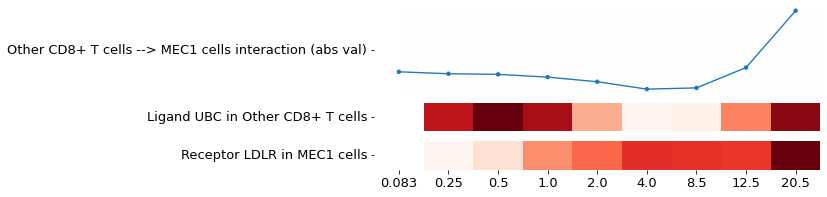

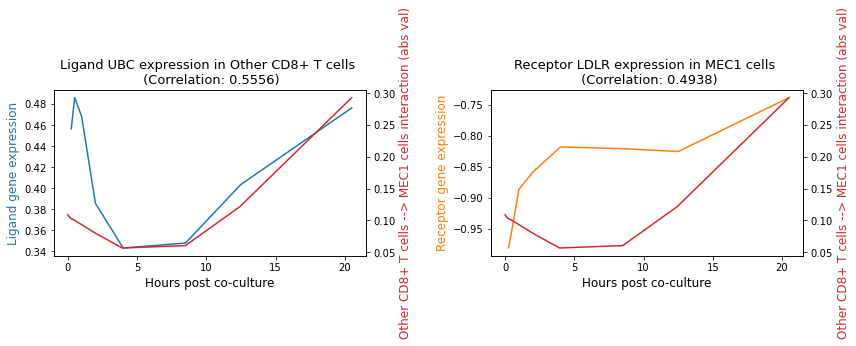



Ligand: B2M
Receptor: LILRB1
Ligand-interaction correlation: 0.2240
Receptor-interaction correlation: 0.8127
Avg ligand/receptor-interaction correlation: 0.5183


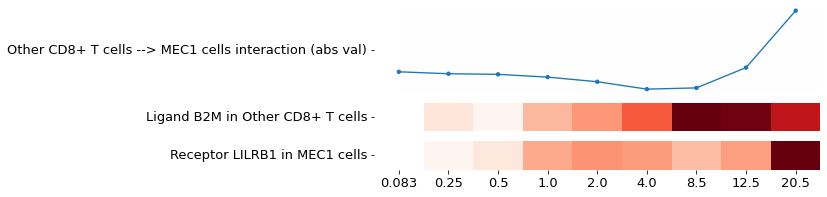

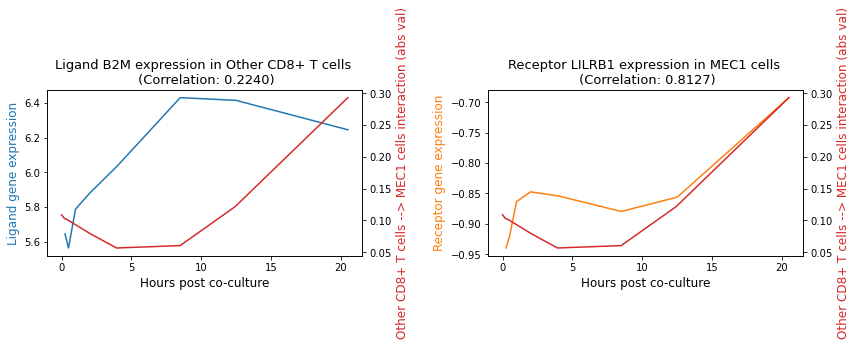



Other CD8+ T cells --> Activated T cells
Ligand: HLA-C
Receptor: CD3G
Ligand-interaction correlation: 0.6326
Receptor-interaction correlation: 0.7571
Avg ligand/receptor-interaction correlation: 0.6948


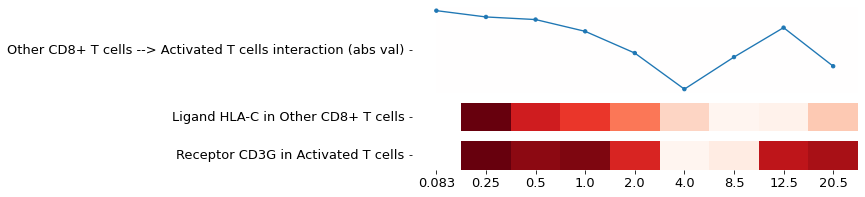

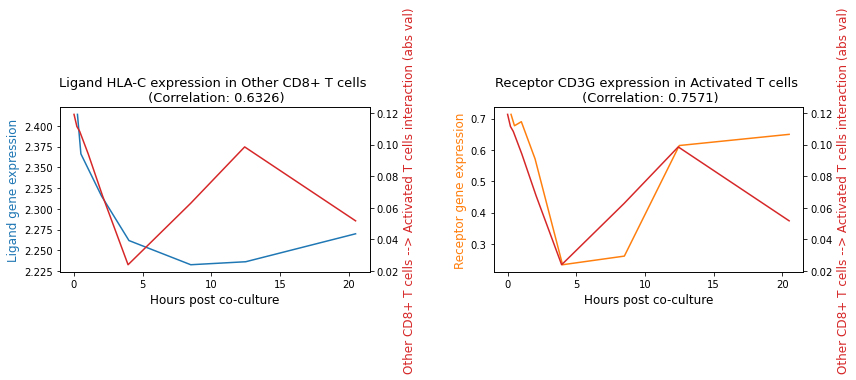



Ligand: HLA-F
Receptor: CD8A
Ligand-interaction correlation: 0.7318
Receptor-interaction correlation: 0.6797
Avg ligand/receptor-interaction correlation: 0.7058


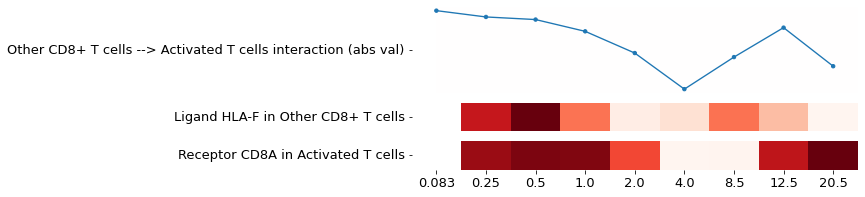

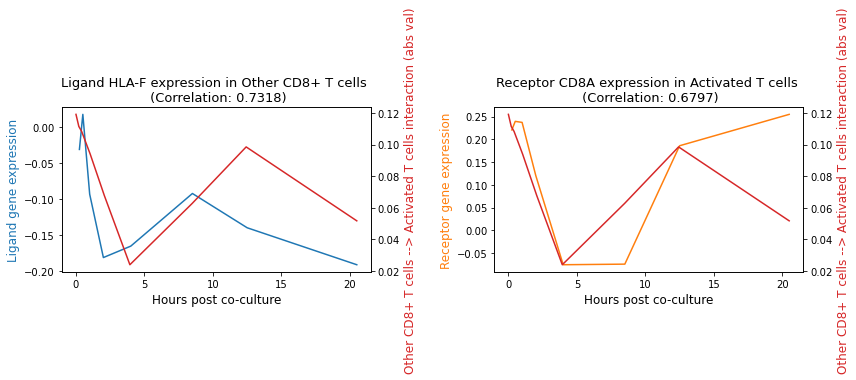



Ligand: GNAI2
Receptor: CXCR3
Ligand-interaction correlation: 0.6387
Receptor-interaction correlation: 0.7434
Avg ligand/receptor-interaction correlation: 0.6910


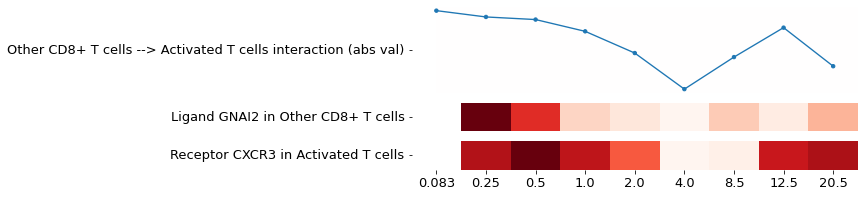

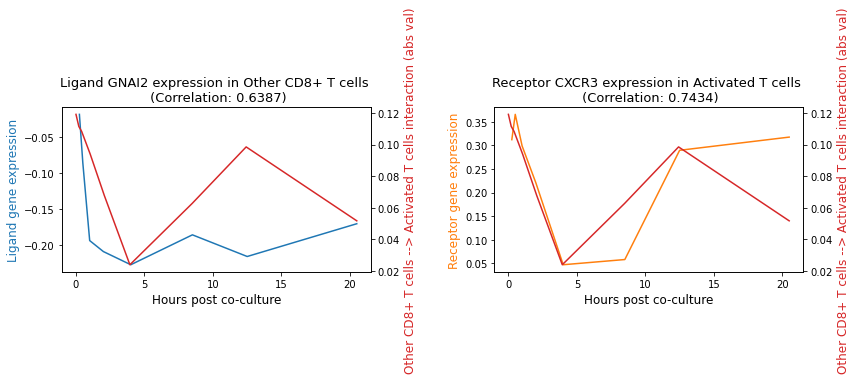



Ligand: HLA-F
Receptor: CD8B
Ligand-interaction correlation: 0.7318
Receptor-interaction correlation: 0.7694
Avg ligand/receptor-interaction correlation: 0.7506


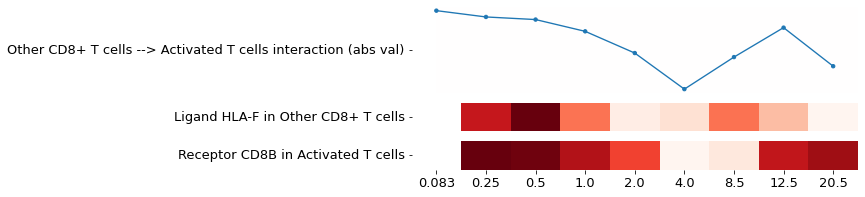

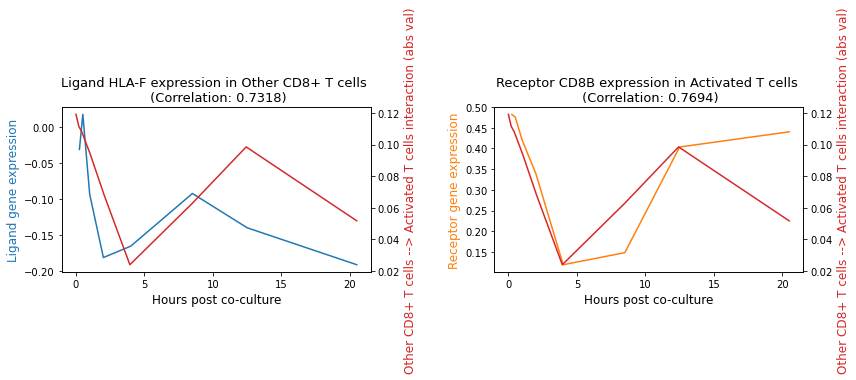



Ligand: GNAI2
Receptor: S1PR4
Ligand-interaction correlation: 0.6387
Receptor-interaction correlation: 0.7471
Avg ligand/receptor-interaction correlation: 0.6929


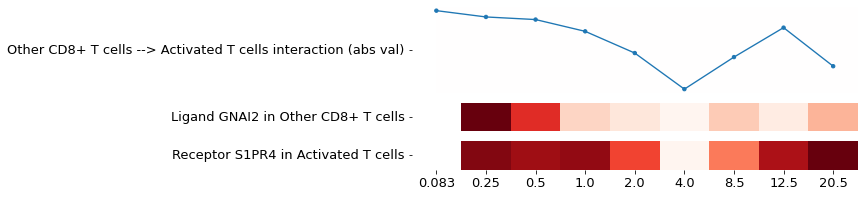

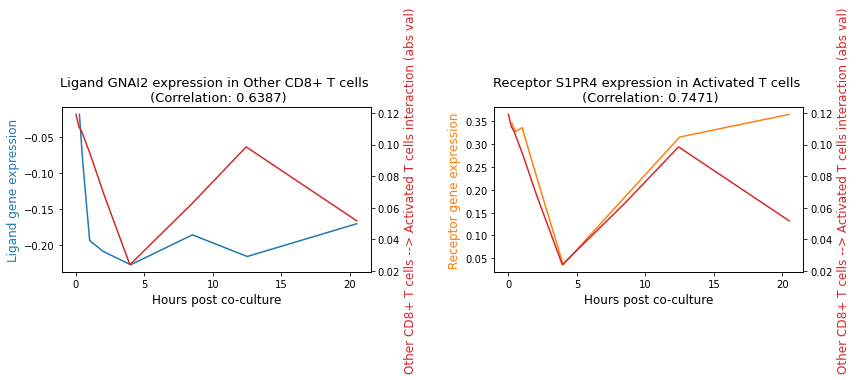



Ligand: HLA-C
Receptor: CD8A
Ligand-interaction correlation: 0.6326
Receptor-interaction correlation: 0.6797
Avg ligand/receptor-interaction correlation: 0.6561


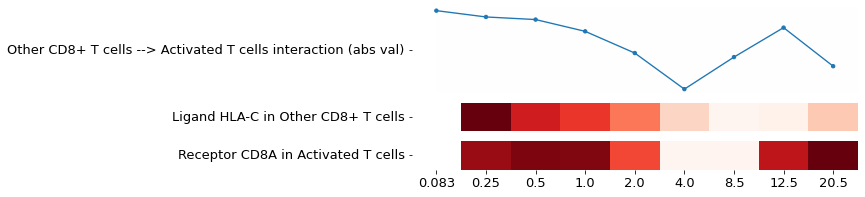

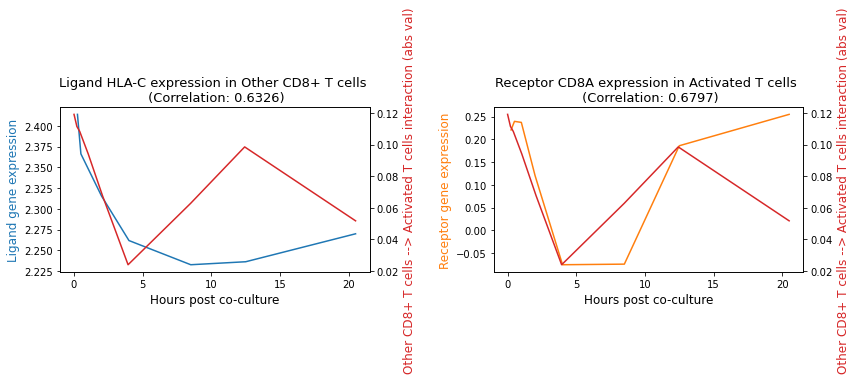



Ligand: HLA-C
Receptor: CD8B
Ligand-interaction correlation: 0.6326
Receptor-interaction correlation: 0.7694
Avg ligand/receptor-interaction correlation: 0.7010


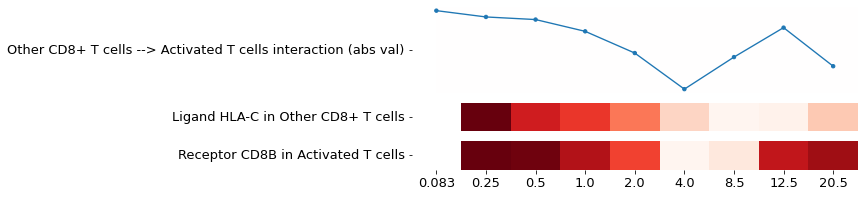

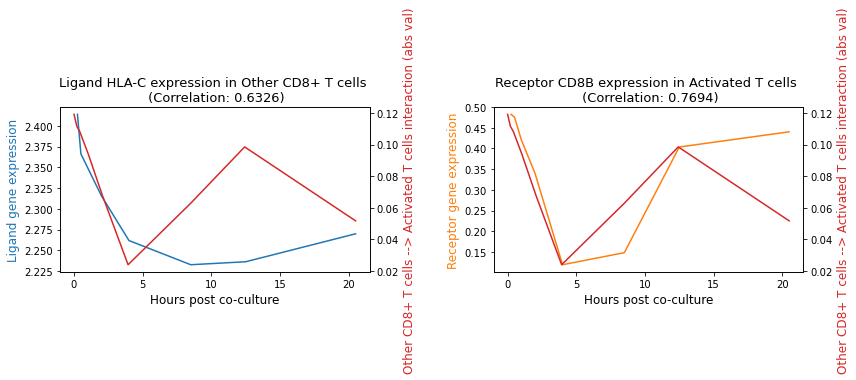



Ligand: GNAI2
Receptor: S1PR1
Ligand-interaction correlation: 0.6387
Receptor-interaction correlation: 0.5947
Avg ligand/receptor-interaction correlation: 0.6167


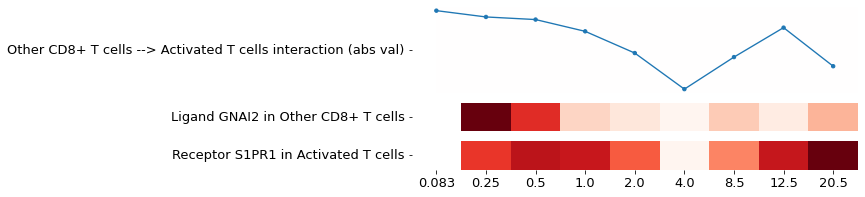

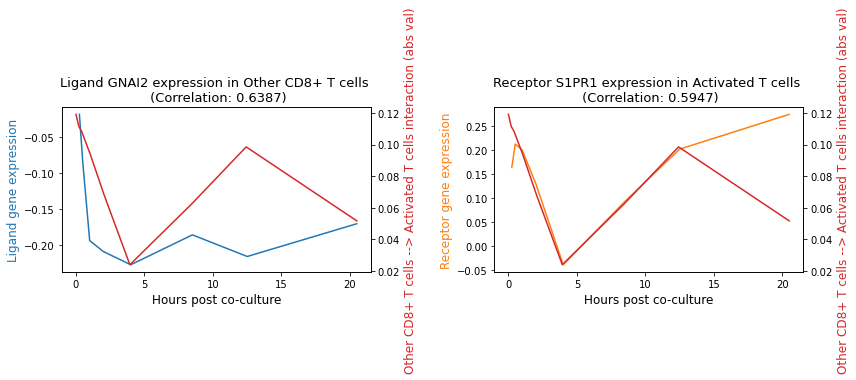



Ligand: HLA-B
Receptor: CD3G
Ligand-interaction correlation: 0.4230
Receptor-interaction correlation: 0.7571
Avg ligand/receptor-interaction correlation: 0.5901


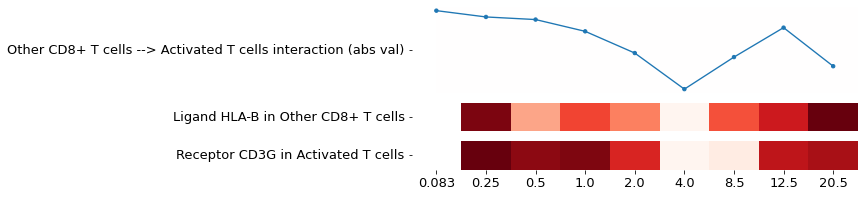

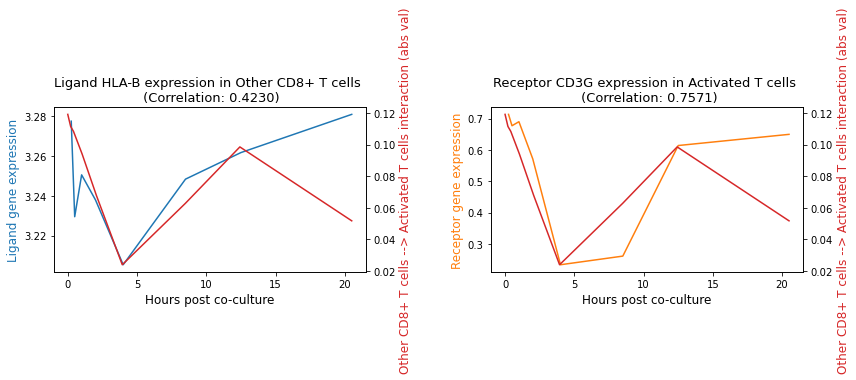



Ligand: CD53
Receptor: CD37
Ligand-interaction correlation: 0.4148
Receptor-interaction correlation: 0.7064
Avg ligand/receptor-interaction correlation: 0.5606


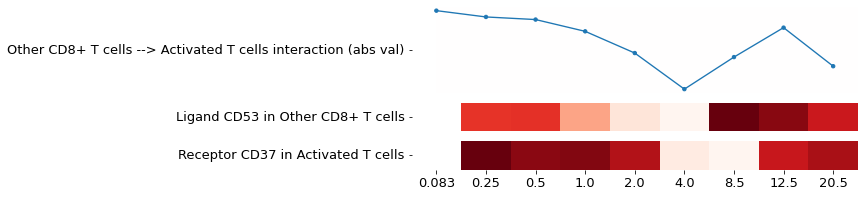

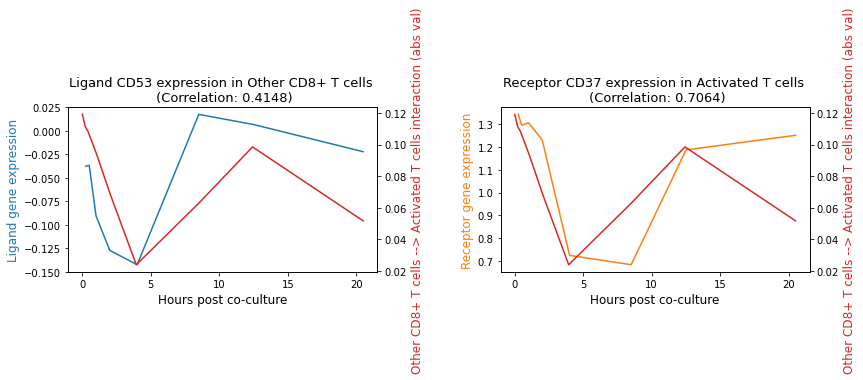



Other CD8+ T cells --> Exhausted T cells
No predicted interactions

Activated T cells --> MEC1 cells
Ligand: ITGA4
Receptor: CD81
Ligand-interaction correlation: 0.5036
Receptor-interaction correlation: 0.7955
Avg ligand/receptor-interaction correlation: 0.6496


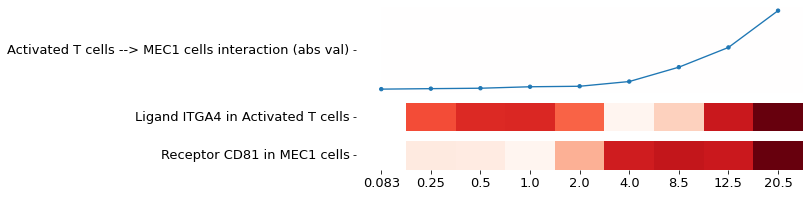

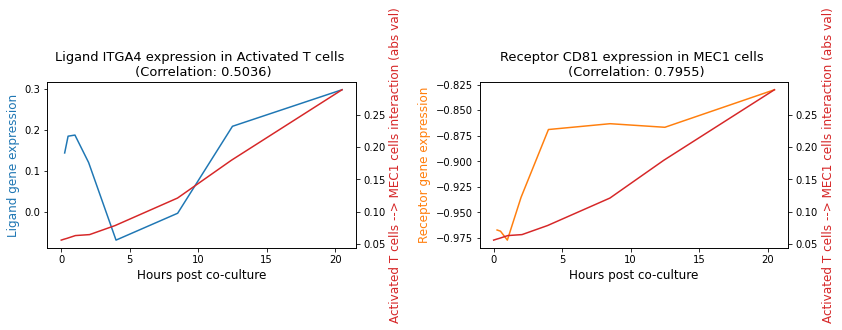



Ligand: HLA-F
Receptor: LILRB1
Ligand-interaction correlation: 0.3956
Receptor-interaction correlation: 0.8550
Avg ligand/receptor-interaction correlation: 0.6253


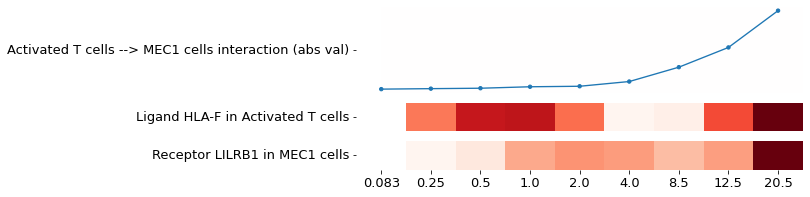

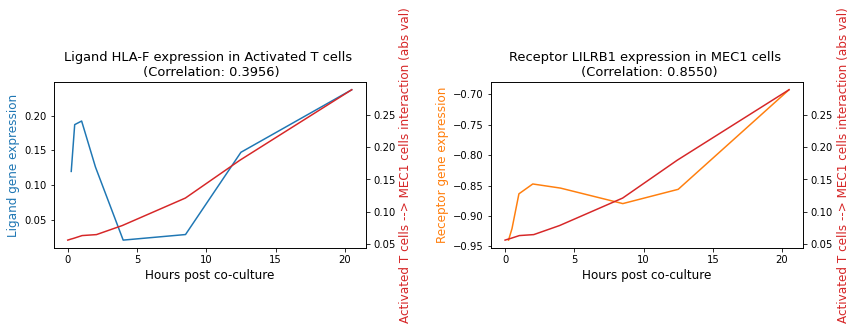



Ligand: SELPLG
Receptor: ITGB2
Ligand-interaction correlation: 0.4804
Receptor-interaction correlation: 0.7793
Avg ligand/receptor-interaction correlation: 0.6299


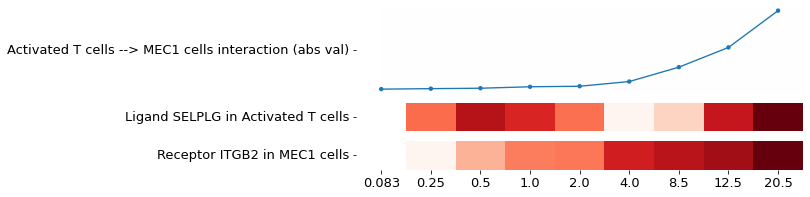

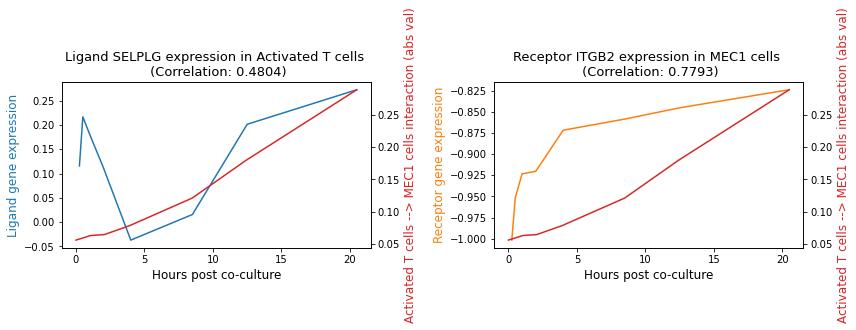



Ligand: ICAM3
Receptor: ITGB2
Ligand-interaction correlation: 0.4141
Receptor-interaction correlation: 0.7793
Avg ligand/receptor-interaction correlation: 0.5967


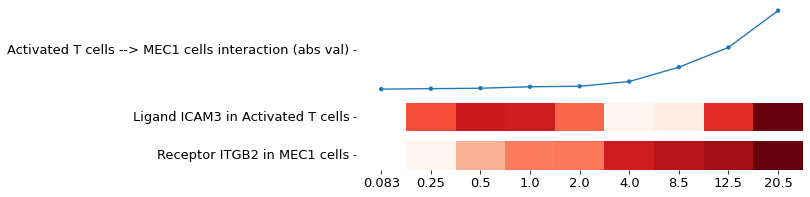

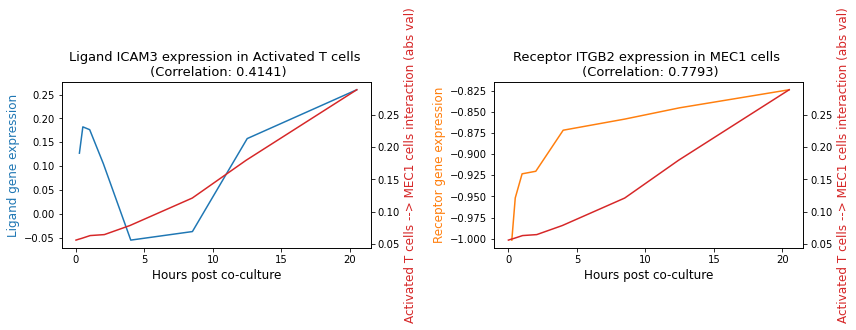



Ligand: ITGA4
Receptor: JAM2
Ligand-interaction correlation: 0.5036
Receptor-interaction correlation: 0.7000
Avg ligand/receptor-interaction correlation: 0.6018


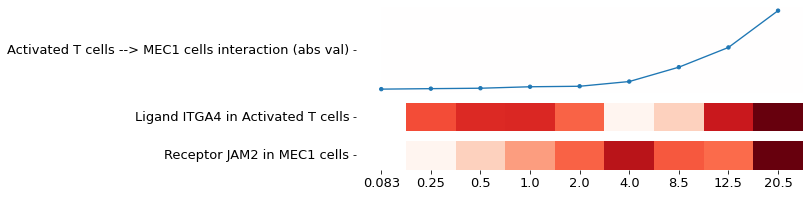

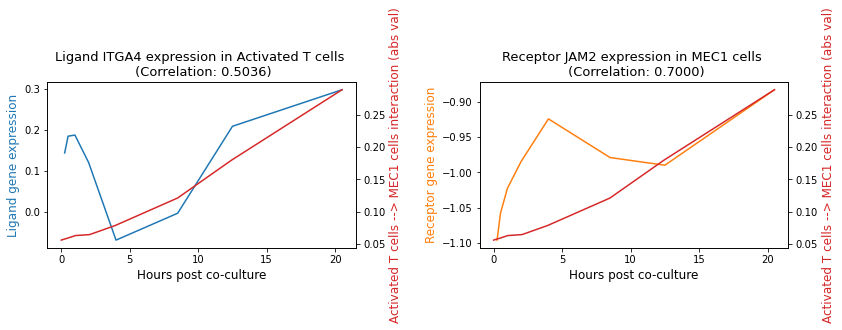



Ligand: ICAM2
Receptor: ITGB2
Ligand-interaction correlation: 0.4086
Receptor-interaction correlation: 0.7793
Avg ligand/receptor-interaction correlation: 0.5939


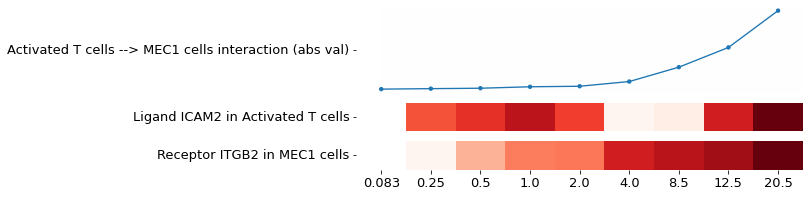

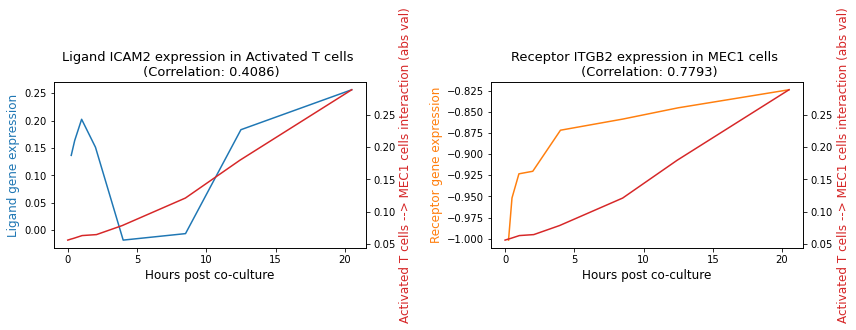



Ligand: HLA-B
Receptor: CANX
Ligand-interaction correlation: 0.2038
Receptor-interaction correlation: 0.9688
Avg ligand/receptor-interaction correlation: 0.5863


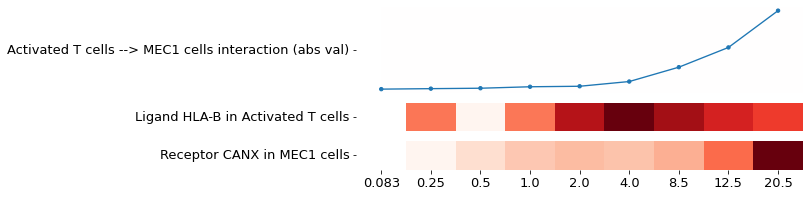

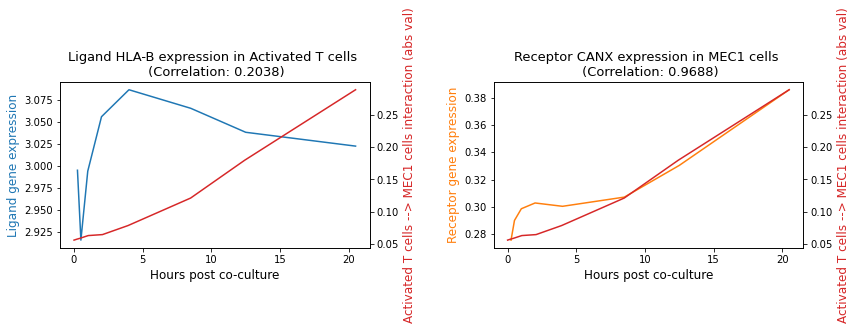



Ligand: ITGB1
Receptor: EFNA5
Ligand-interaction correlation: 0.1971
Receptor-interaction correlation: 0.8679
Avg ligand/receptor-interaction correlation: 0.5325


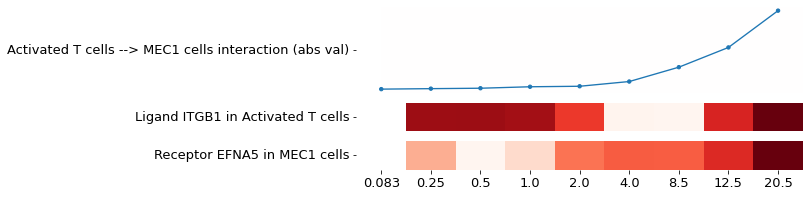

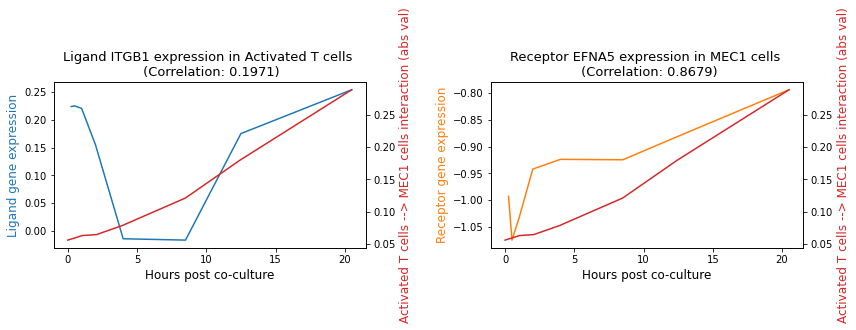



Ligand: ITGB1
Receptor: CD81
Ligand-interaction correlation: 0.1971
Receptor-interaction correlation: 0.7955
Avg ligand/receptor-interaction correlation: 0.4963


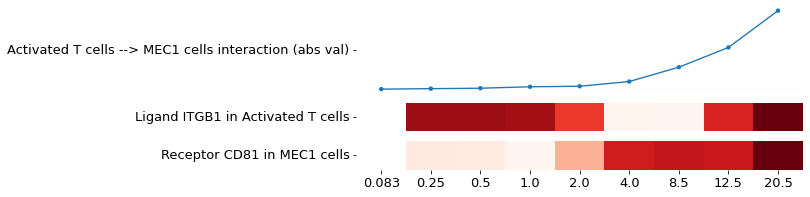

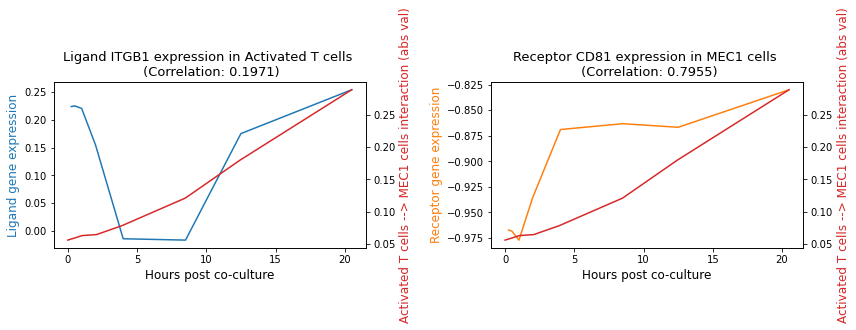



Ligand: HLA-B
Receptor: LILRB1
Ligand-interaction correlation: 0.2038
Receptor-interaction correlation: 0.8550
Avg ligand/receptor-interaction correlation: 0.5294


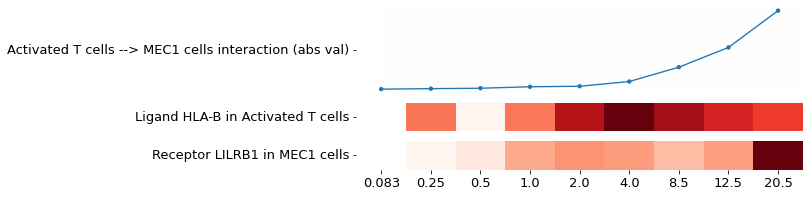

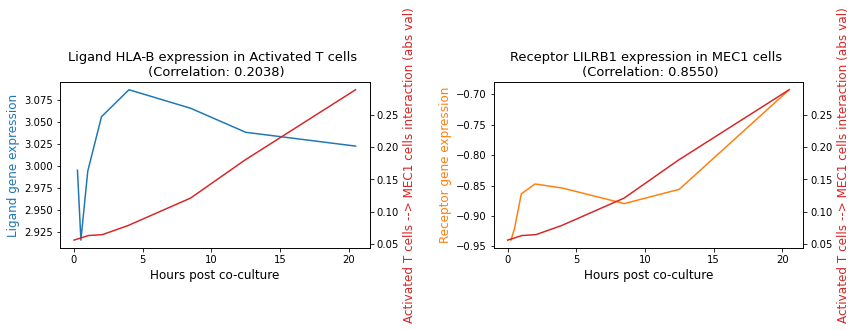



Activated T cells --> Other CD8+ T cells
Ligand: SELL
Receptor: SELPLG
Ligand-interaction correlation: 0.5807
Receptor-interaction correlation: 0.6523
Avg ligand/receptor-interaction correlation: 0.6165


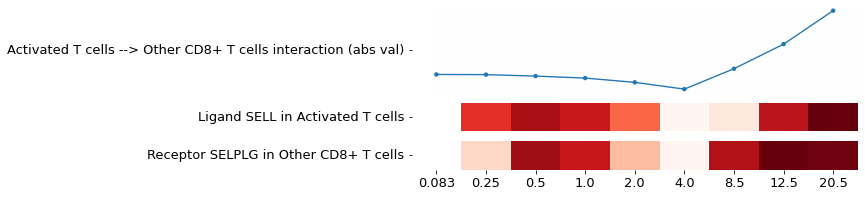

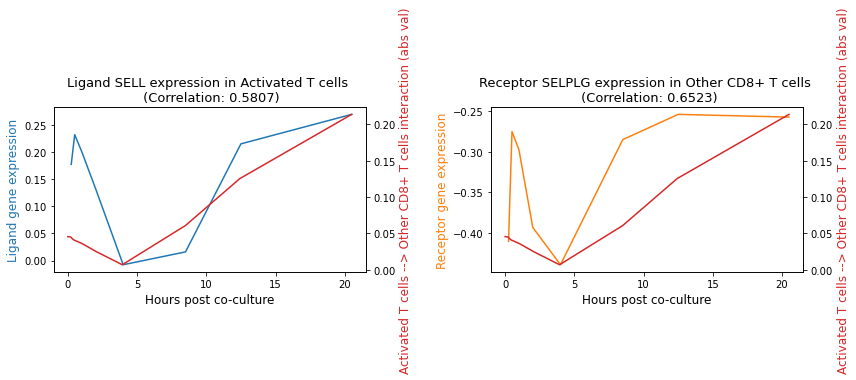



Ligand: ICAM3
Receptor: ITGAL
Ligand-interaction correlation: 0.6050
Receptor-interaction correlation: 0.4810
Avg ligand/receptor-interaction correlation: 0.5430


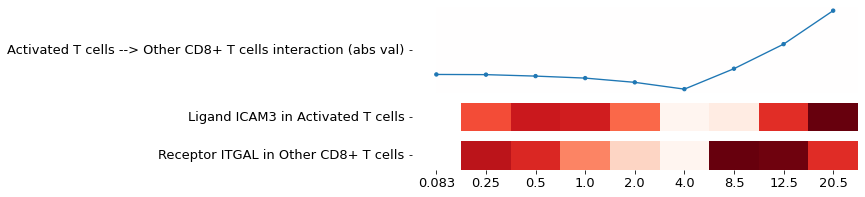

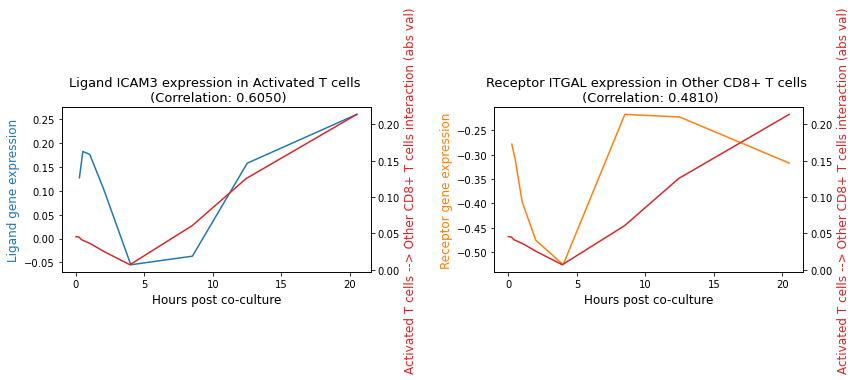



Ligand: ICAM2
Receptor: ITGAL
Ligand-interaction correlation: 0.5871
Receptor-interaction correlation: 0.4810
Avg ligand/receptor-interaction correlation: 0.5341


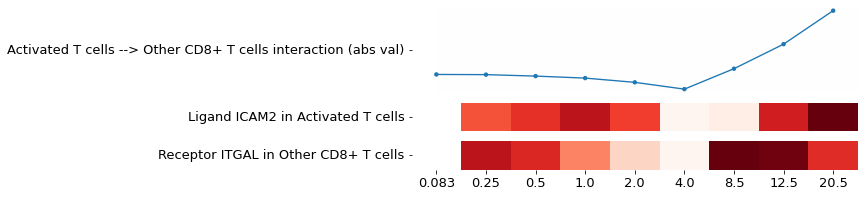

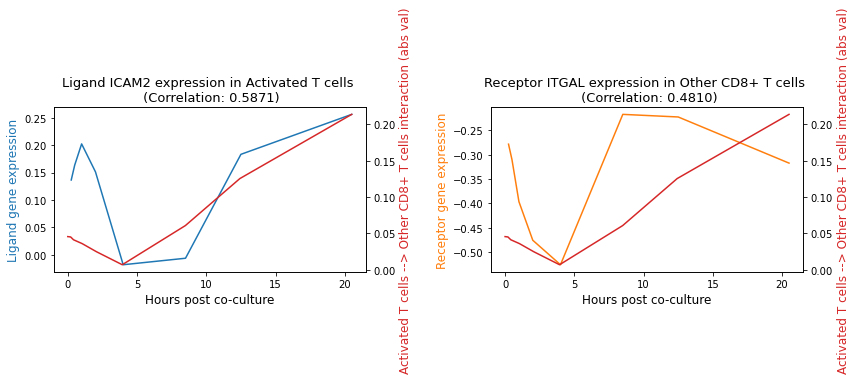



Ligand: TIMP1
Receptor: CD63
Ligand-interaction correlation: 0.3501
Receptor-interaction correlation: 0.6898
Avg ligand/receptor-interaction correlation: 0.5200


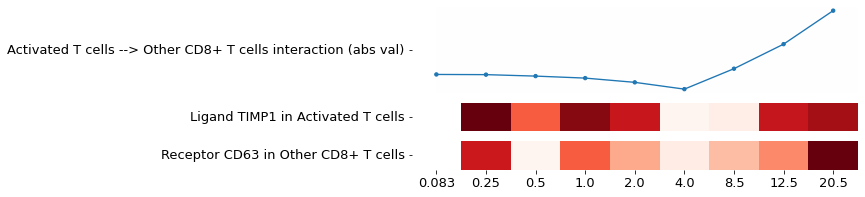

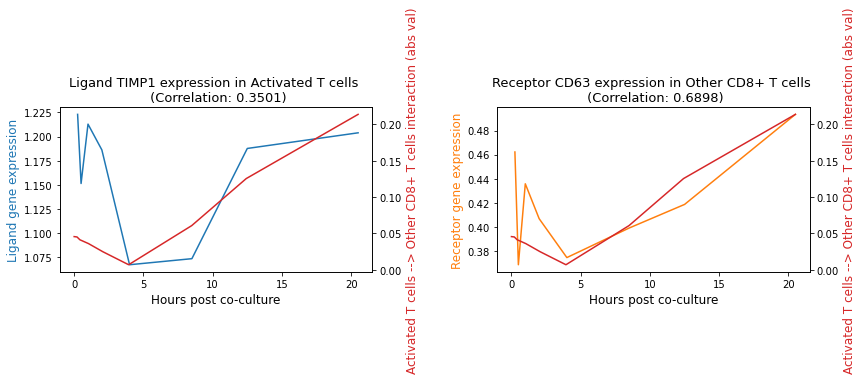



Ligand: KLRB1
Receptor: CLEC2D
Ligand-interaction correlation: 0.7478
Receptor-interaction correlation: 0.1138
Avg ligand/receptor-interaction correlation: 0.4308


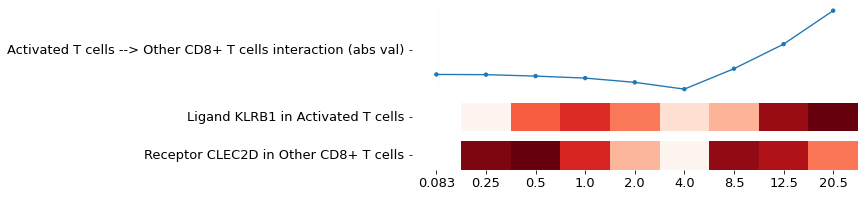

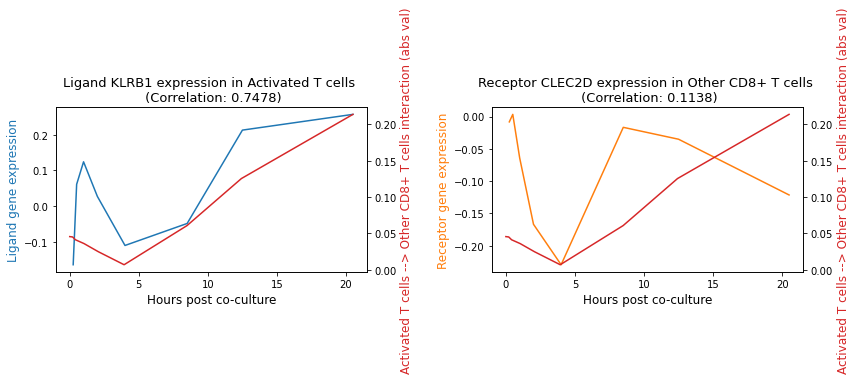



Ligand: HLA-C
Receptor: CD3D
Ligand-interaction correlation: 0.3363
Receptor-interaction correlation: 0.6117
Avg ligand/receptor-interaction correlation: 0.4740


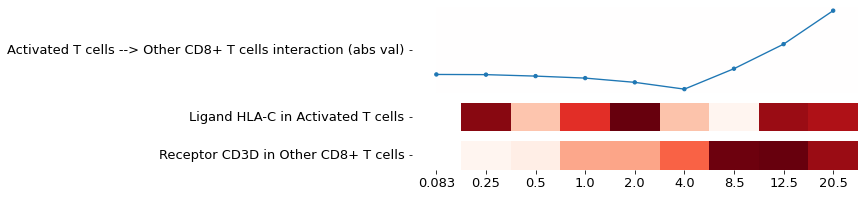

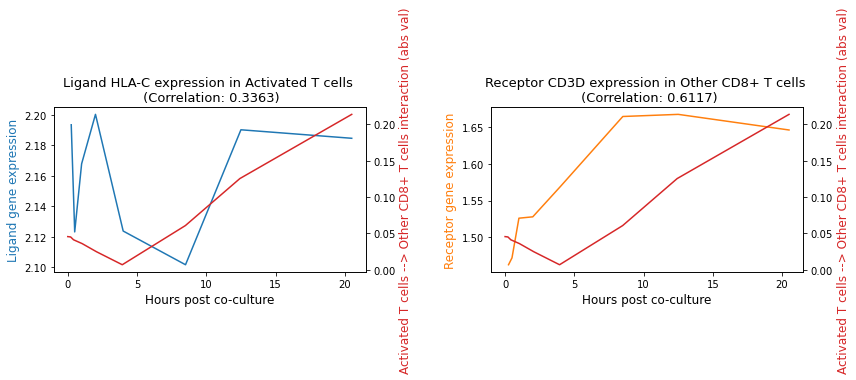



Ligand: HLA-F
Receptor: CD8A
Ligand-interaction correlation: 0.5718
Receptor-interaction correlation: 0.2375
Avg ligand/receptor-interaction correlation: 0.4046


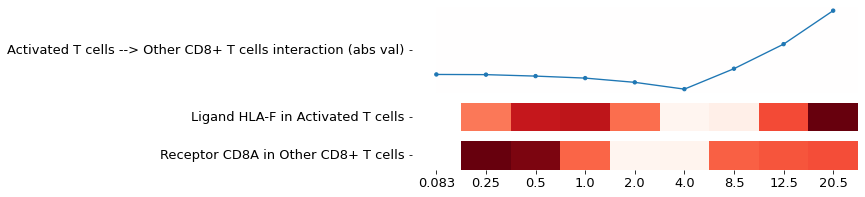

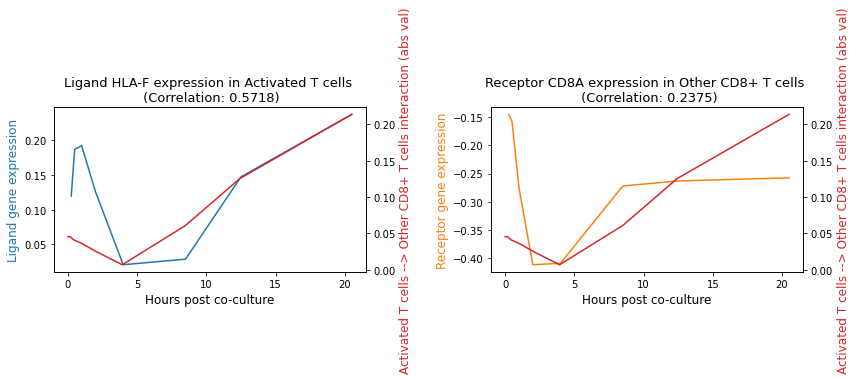



Ligand: HLA-C
Receptor: CD53
Ligand-interaction correlation: 0.3363
Receptor-interaction correlation: 0.5806
Avg ligand/receptor-interaction correlation: 0.4585


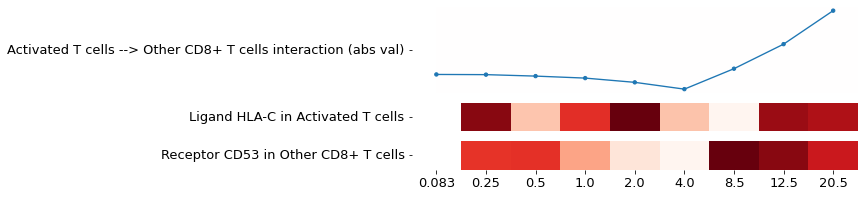

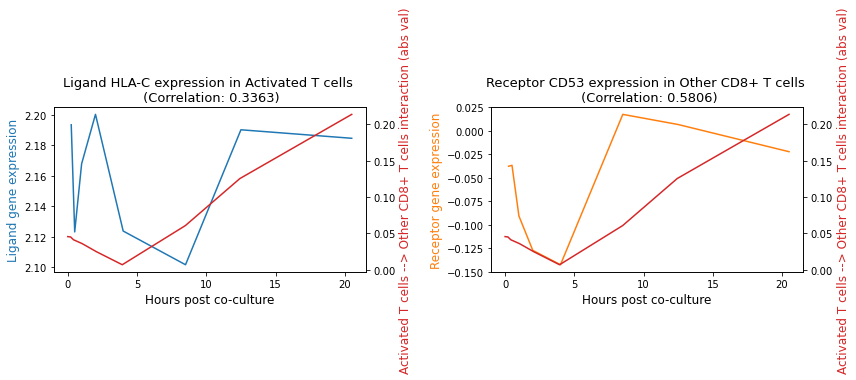



Ligand: IL21
Receptor: IL4R
Ligand-interaction correlation: -0.068
Receptor-interaction correlation: 0.6762
Avg ligand/receptor-interaction correlation: 0.3037


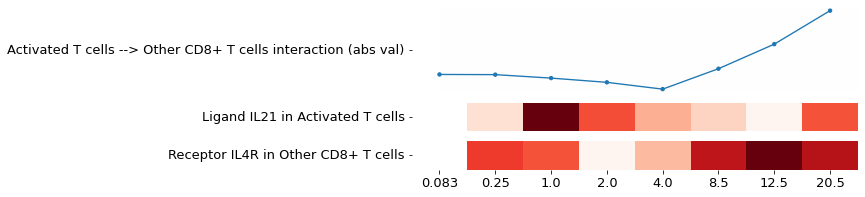

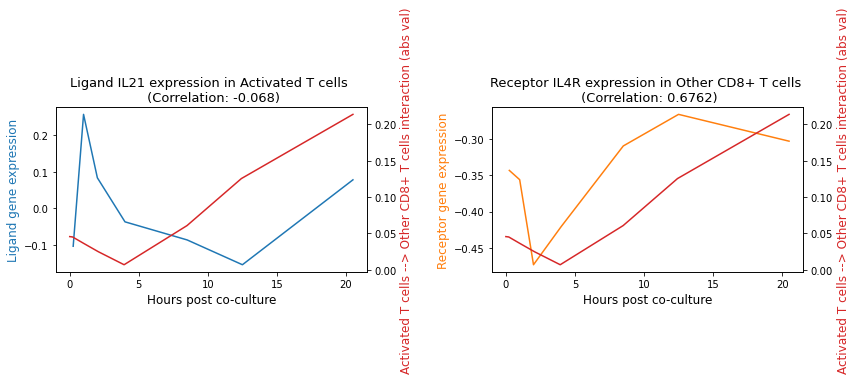



Ligand: HLA-A
Receptor: CD3D
Ligand-interaction correlation: 0.0425
Receptor-interaction correlation: 0.6117
Avg ligand/receptor-interaction correlation: 0.3271


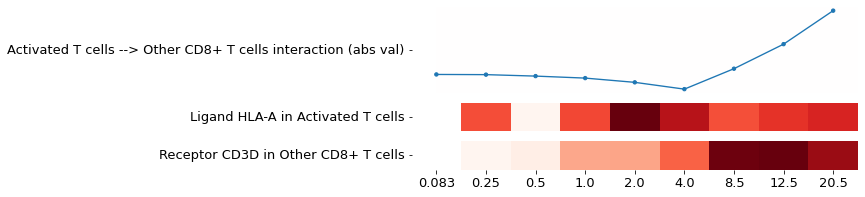

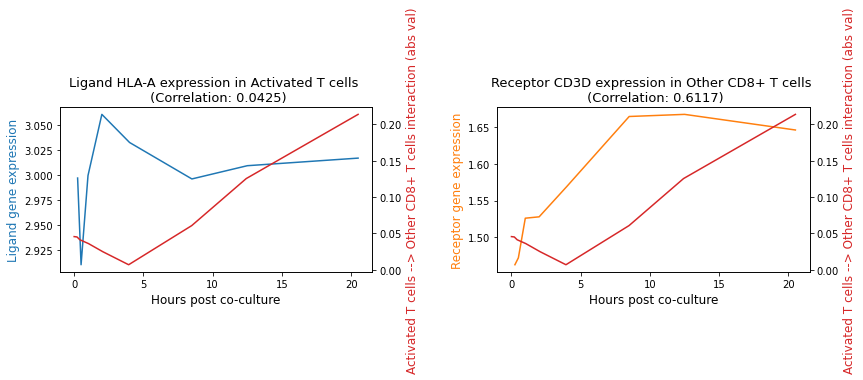



Activated T cells --> Exhausted T cells
Ligand: KLRB1
Receptor: CLEC2D
Ligand-interaction correlation: 0.5874
Receptor-interaction correlation: -0.063
Avg ligand/receptor-interaction correlation: 0.2617


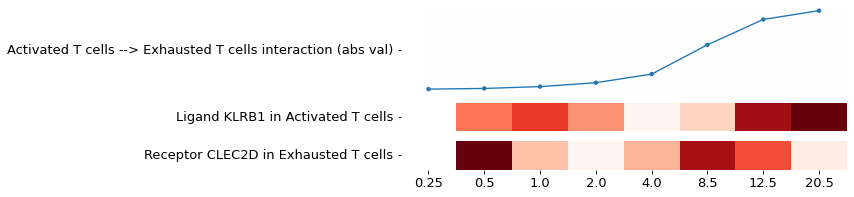

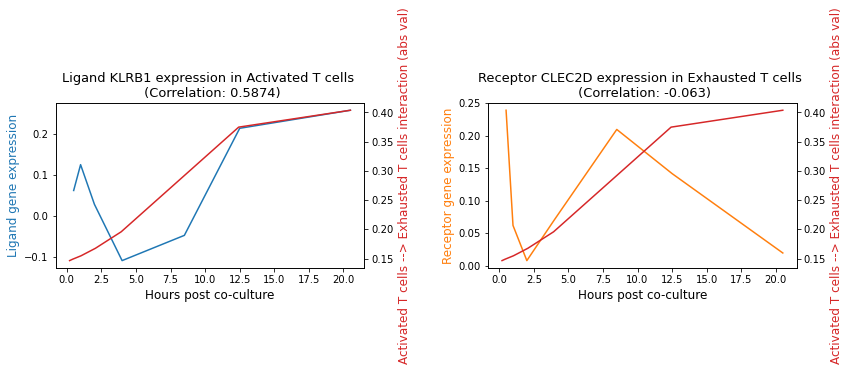



Ligand: CD48
Receptor: CD2
Ligand-interaction correlation: -0.189
Receptor-interaction correlation: 0.4420
Avg ligand/receptor-interaction correlation: 0.1263


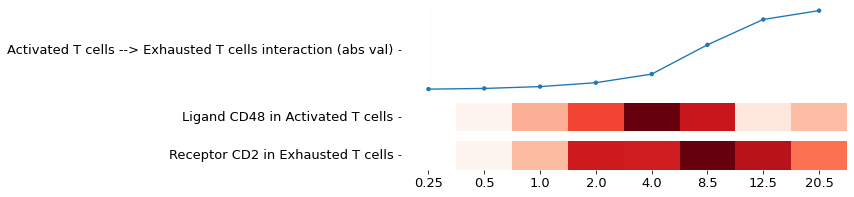

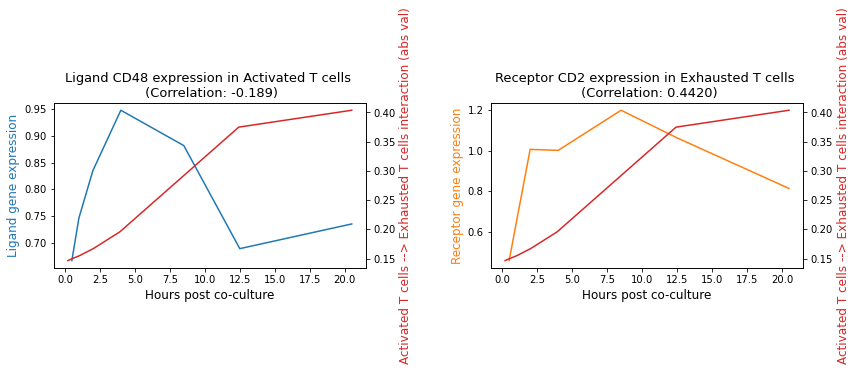



Ligand: ITGB1
Receptor: CD151
Ligand-interaction correlation: 0.2199
Receptor-interaction correlation: 0.4820
Avg ligand/receptor-interaction correlation: 0.3510


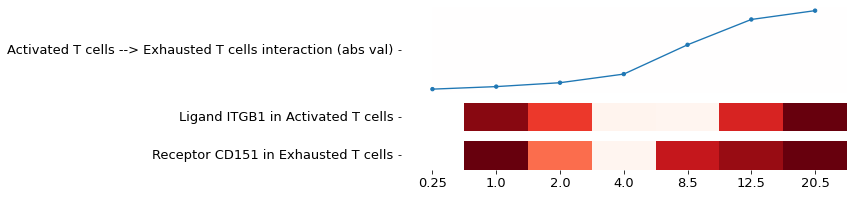

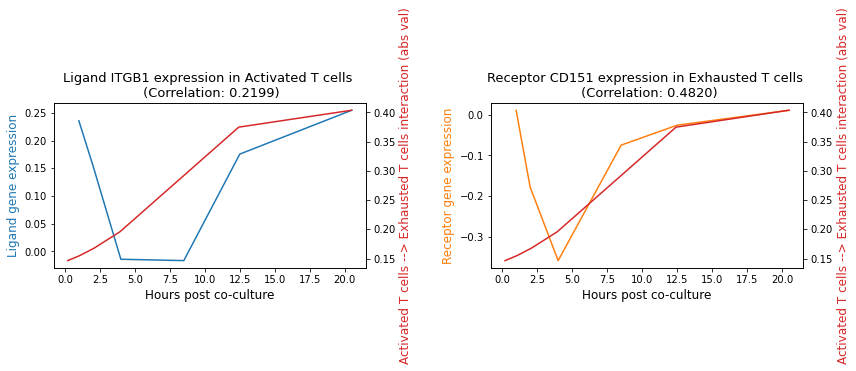



Ligand: HLA-E
Receptor: KLRD1
Ligand-interaction correlation: -0.526
Receptor-interaction correlation: 0.1262
Avg ligand/receptor-interaction correlation: -0.199


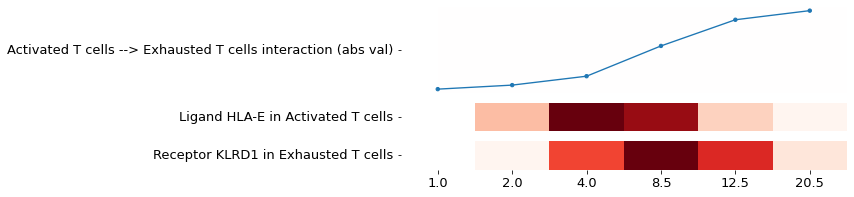

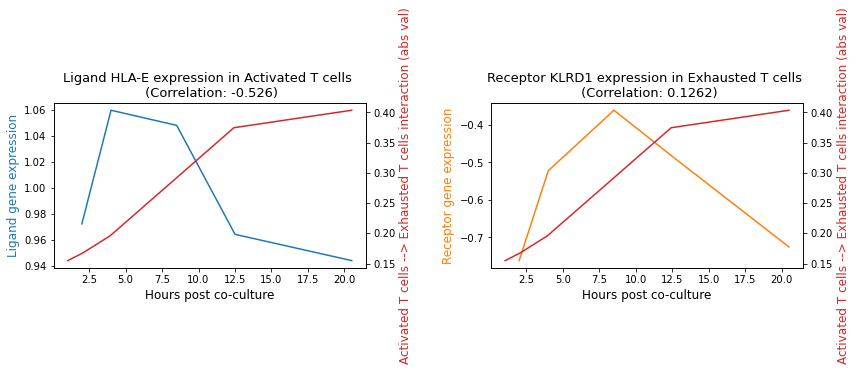



Ligand: CD5
Receptor: TNFRSF25
Ligand-interaction correlation: 0.6178
Receptor-interaction correlation: 0.2416
Avg ligand/receptor-interaction correlation: 0.4297


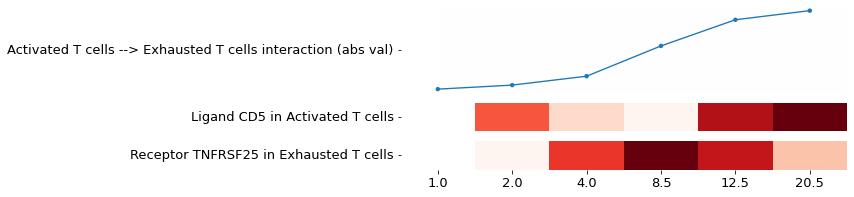

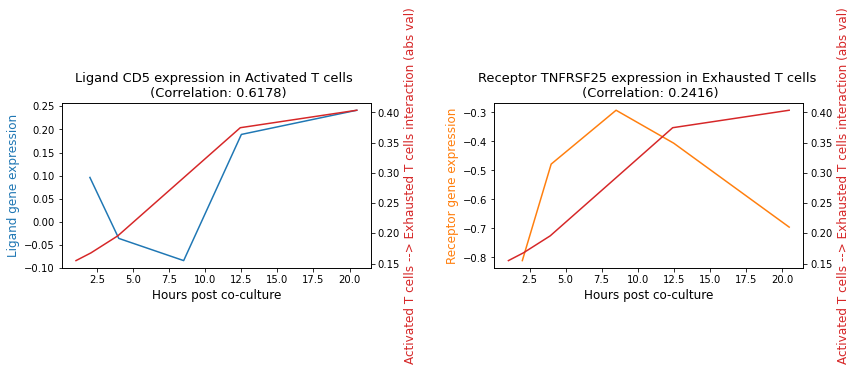



Ligand: HLA-B
Receptor: KLRD1
Ligand-interaction correlation: -0.792
Receptor-interaction correlation: 0.1262
Avg ligand/receptor-interaction correlation: -0.333


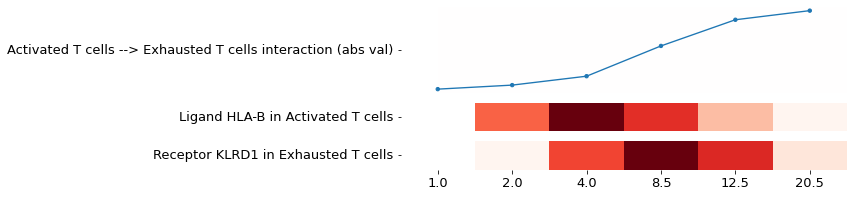

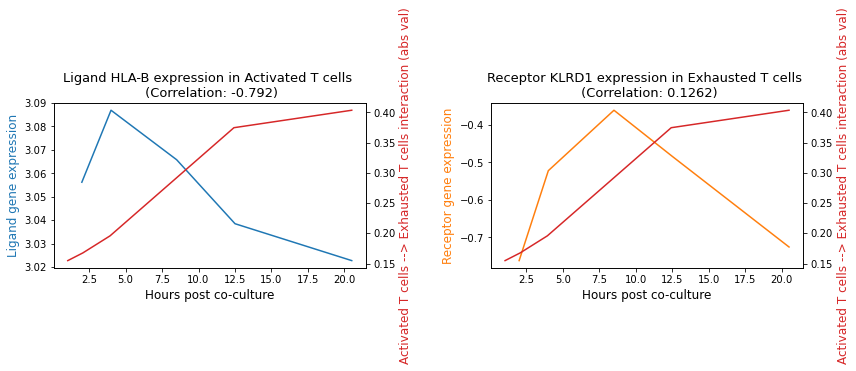



Ligand: ITGA4
Receptor: CD82
Ligand-interaction correlation: 0.3704
Receptor-interaction correlation: -0.092
Avg ligand/receptor-interaction correlation: 0.1387


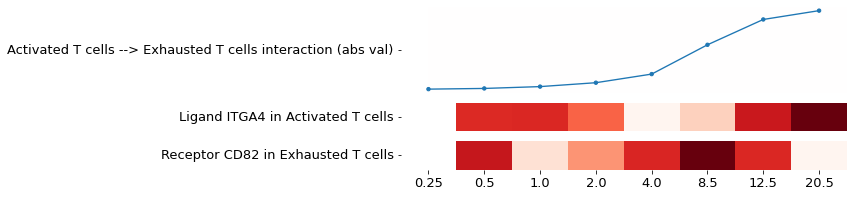

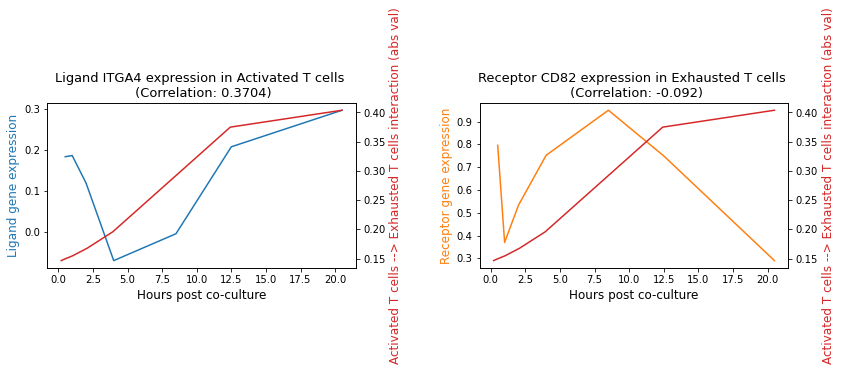



Ligand: PRNP
Receptor: TNFRSF25
Ligand-interaction correlation: 0.2303
Receptor-interaction correlation: 0.2416
Avg ligand/receptor-interaction correlation: 0.2359


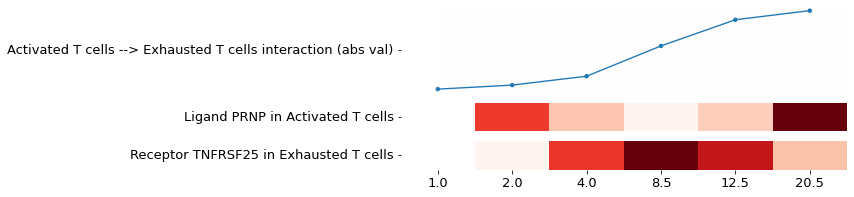

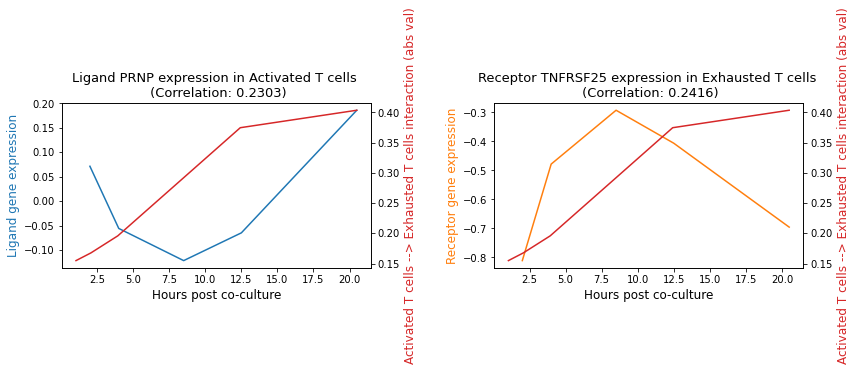



Ligand: HLA-A
Receptor: KLRD1
Ligand-interaction correlation: -0.712
Receptor-interaction correlation: 0.1262
Avg ligand/receptor-interaction correlation: -0.293


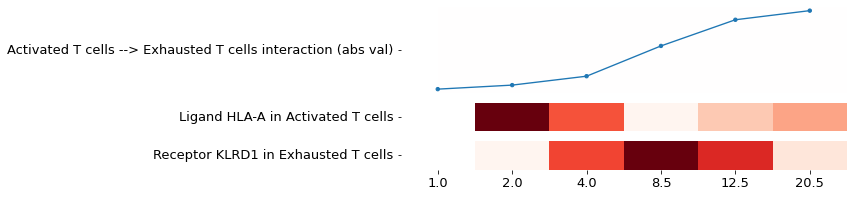

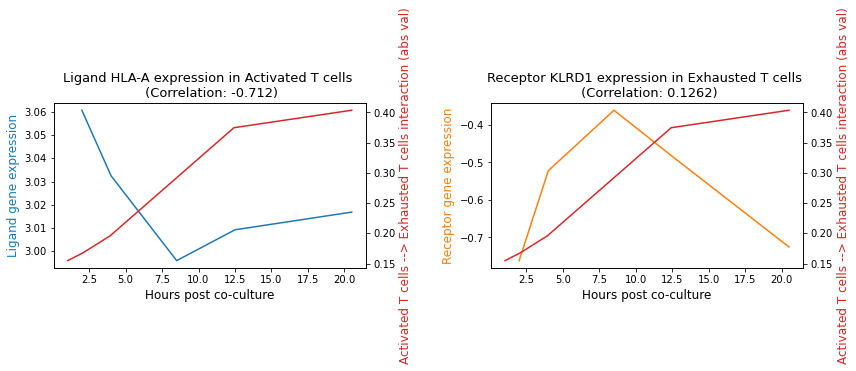



Ligand: B2M
Receptor: KLRD1
Ligand-interaction correlation: -0.847
Receptor-interaction correlation: 0.1262
Avg ligand/receptor-interaction correlation: -0.360


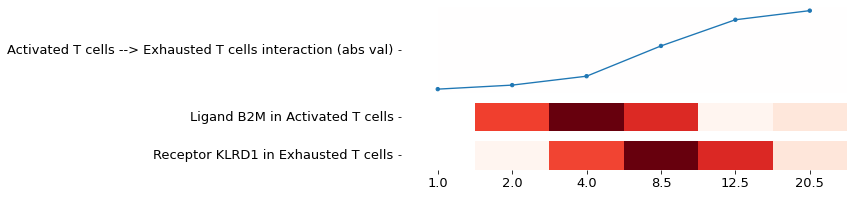

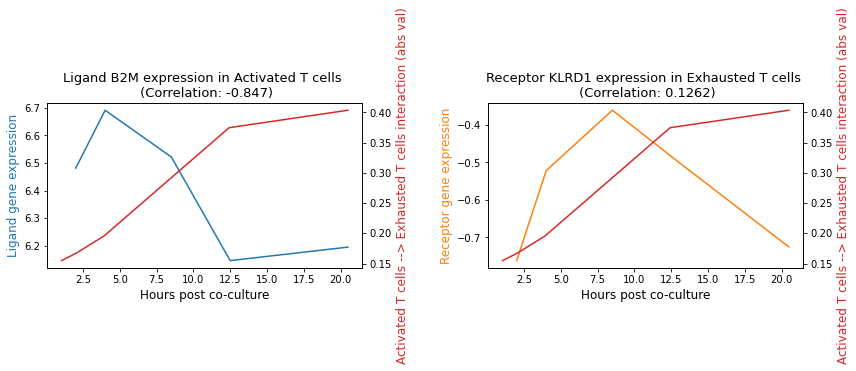



Exhausted T cells --> MEC1 cells
Ligand: CALM2
Receptor: KCNQ5
Ligand-interaction correlation: 0.7315
Receptor-interaction correlation: 0.8759
Avg ligand/receptor-interaction correlation: 0.8037


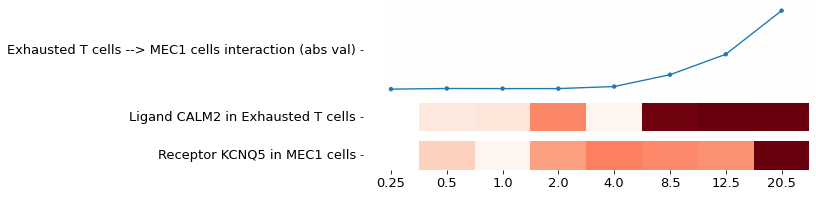

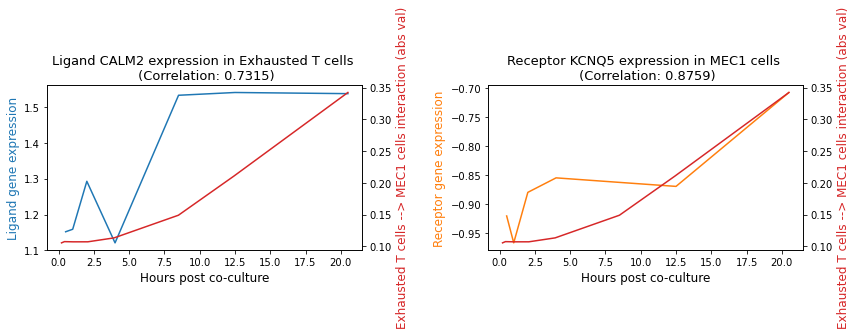



Ligand: YBX1
Receptor: NOTCH1
Ligand-interaction correlation: 0.7820
Receptor-interaction correlation: 0.9450
Avg ligand/receptor-interaction correlation: 0.8635


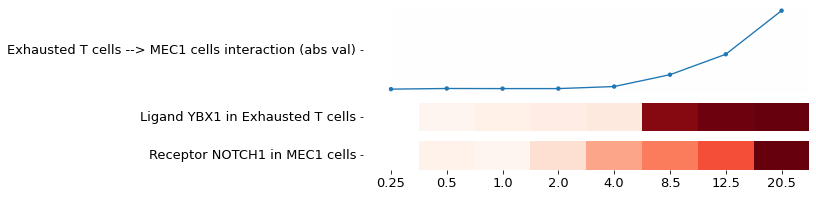

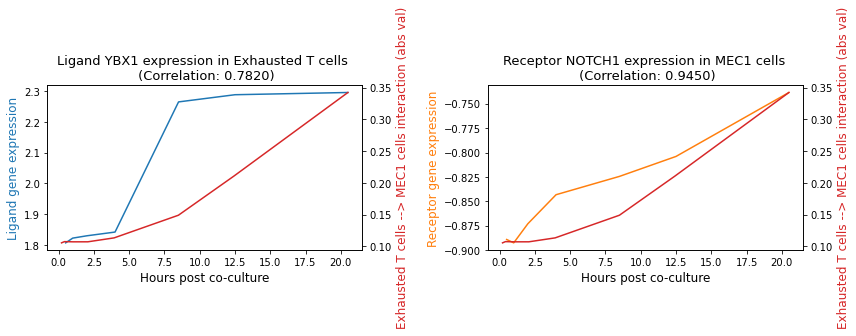



Ligand: MIF
Receptor: CXCR4
Ligand-interaction correlation: 0.7801
Receptor-interaction correlation: 0.8257
Avg ligand/receptor-interaction correlation: 0.8029


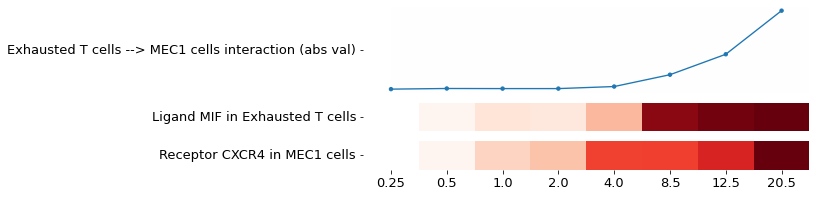

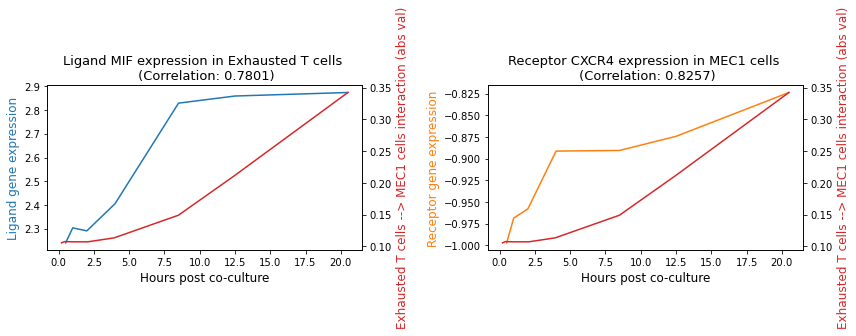



Ligand: CALM2
Receptor: INSR
Ligand-interaction correlation: 0.7315
Receptor-interaction correlation: 0.8299
Avg ligand/receptor-interaction correlation: 0.7807


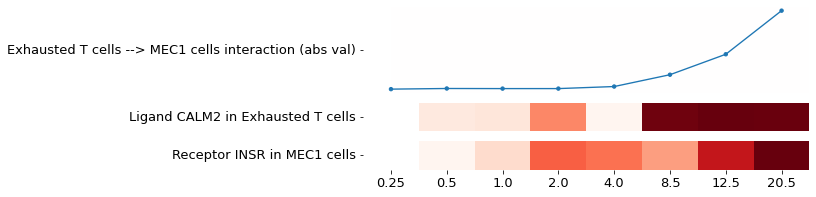

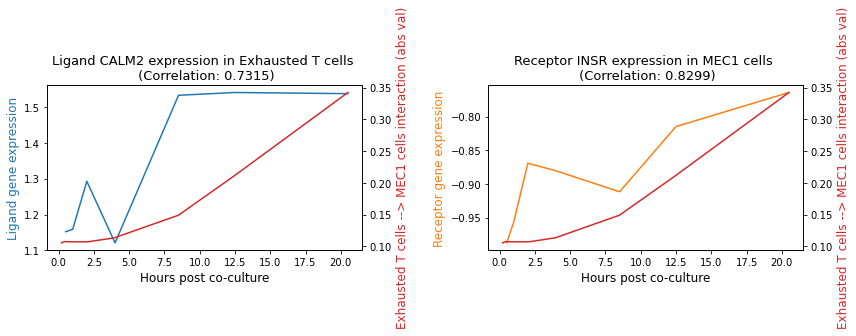



Ligand: BSG
Receptor: SLC16A1
Ligand-interaction correlation: 0.5626
Receptor-interaction correlation: 0.9361
Avg ligand/receptor-interaction correlation: 0.7494


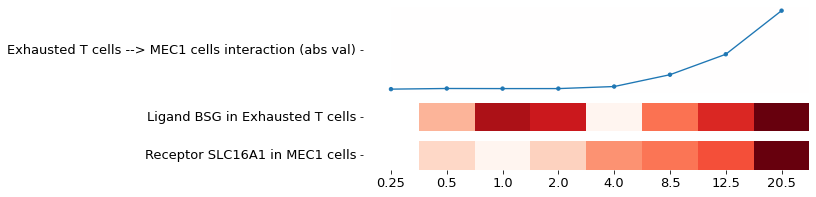

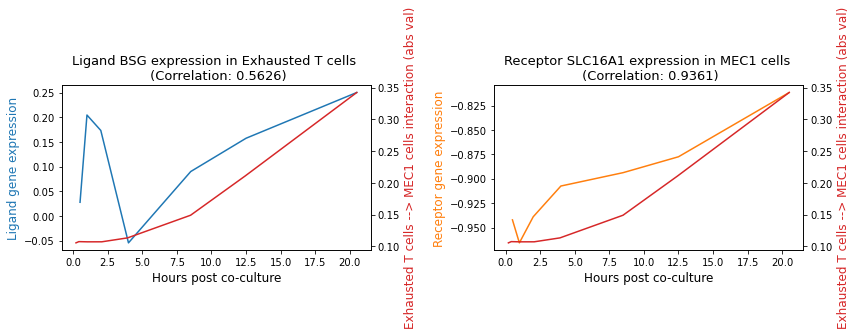



Ligand: UBB
Receptor: TGFBR1
Ligand-interaction correlation: 0.6729
Receptor-interaction correlation: 0.8100
Avg ligand/receptor-interaction correlation: 0.7415


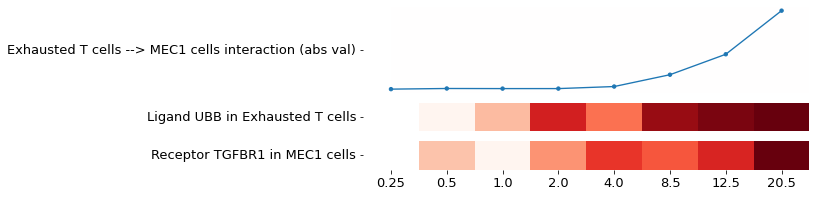

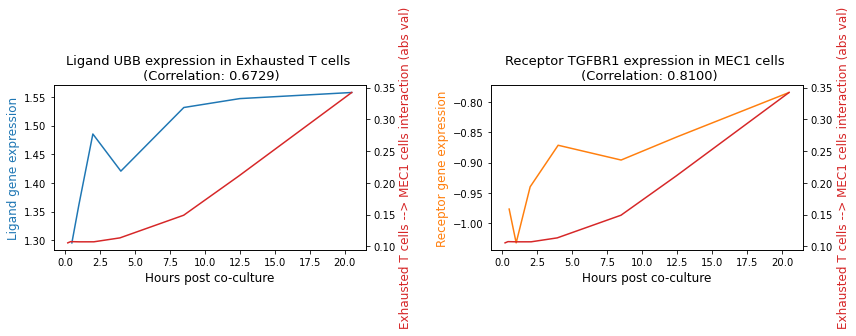



Ligand: FABP5
Receptor: RXRA
Ligand-interaction correlation: 0.6551
Receptor-interaction correlation: 0.8317
Avg ligand/receptor-interaction correlation: 0.7434


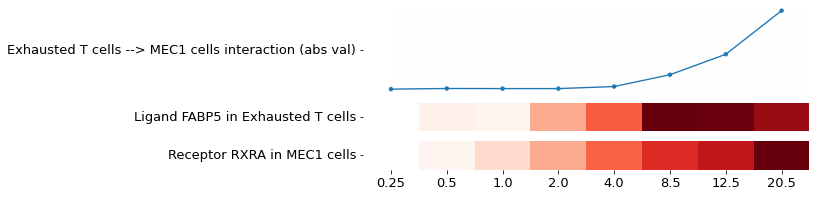

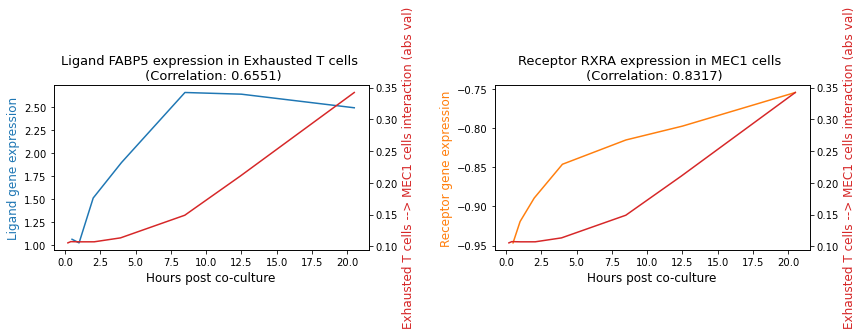



Ligand: CD47
Receptor: SIRPA
Ligand-interaction correlation: 0.5365
Receptor-interaction correlation: 0.9394
Avg ligand/receptor-interaction correlation: 0.7379


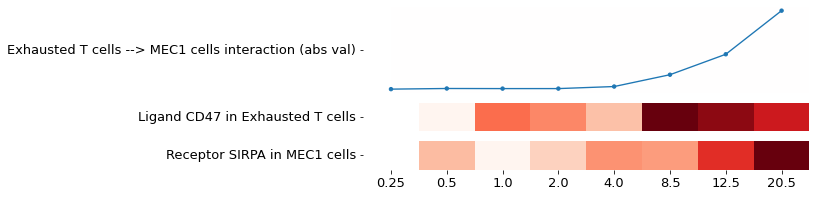

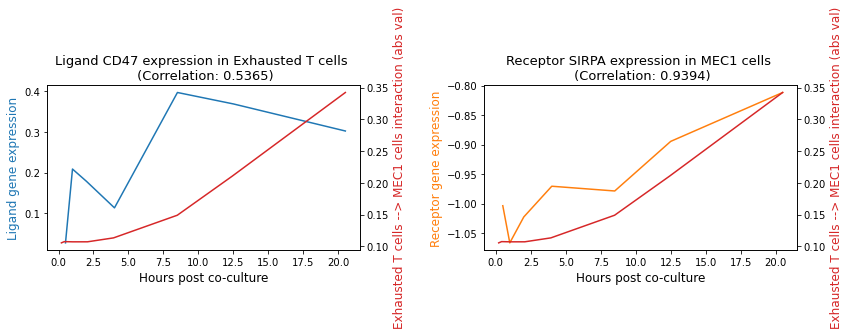



Ligand: LMAN1
Receptor: MCFD2
Ligand-interaction correlation: 0.7077
Receptor-interaction correlation: 0.7827
Avg ligand/receptor-interaction correlation: 0.7452


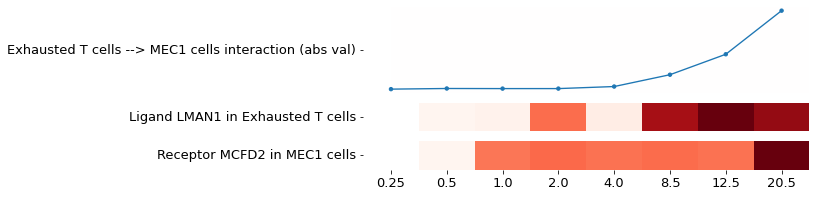

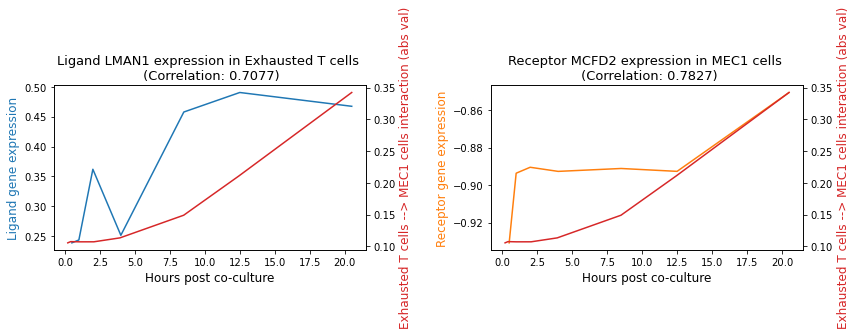



Ligand: UBB
Receptor: LDLR
Ligand-interaction correlation: 0.6729
Receptor-interaction correlation: 0.7843
Avg ligand/receptor-interaction correlation: 0.7286


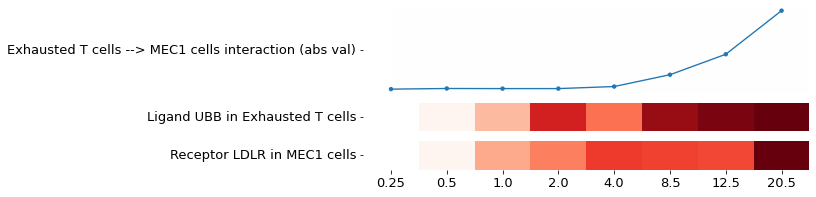

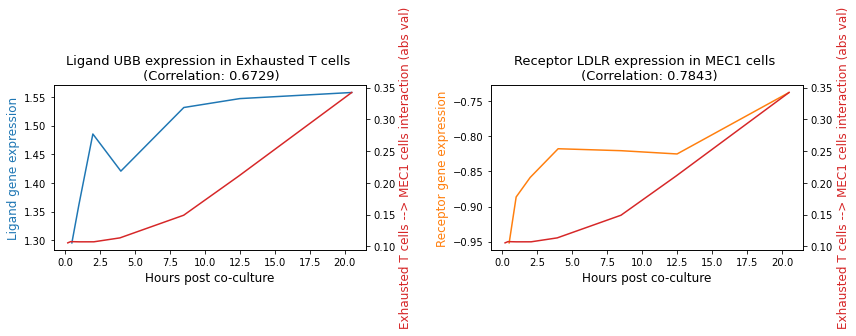



Exhausted T cells --> Other CD8+ T cells
No predicted interactions

Exhausted T cells --> Activated T cells
No predicted interactions



In [24]:
min_exp_threshold = -2
sliding_window_length = 2

for source_cluster in tqdm_notebook(cell_types):
    for target_cluster in cell_types:
        if source_cluster == target_cluster: continue
        if source_cluster not in cluster_to_degs or target_cluster not in cluster_to_degs: continue
        print(source_cluster, '-->', target_cluster)
        
        source_cluster_index = list(cell_types).index(source_cluster)
        source_cluster_cells = gene_exp_df[metadata_df['cell_type'] == source_cluster]
        source_cluster_degs = cluster_to_degs[source_cluster]
        
        target_cluster_index = list(cell_types).index(target_cluster)
        target_cluster_cells = gene_exp_df[metadata_df['cell_type'] == target_cluster]
        target_cluster_degs = cluster_to_degs[target_cluster]
        
        source_target_inferred_interaction_abs_val = np.abs(W[:, target_cluster_index, source_cluster_index])
        if source_target_inferred_interaction_abs_val.all() == 0:
            print("No predicted interactions\n")
            continue
        
        top_rl_pairs_df = pd.read_csv(f'figures/CAR-T/DIISCO_top_RL_pairs/{source_cluster} --> {target_cluster}.csv')
        top_rl_pairs_df = top_rl_pairs_df.head(10)
        
        for _, rl_pair in top_rl_pairs_df.iterrows():
            ligand_gene = rl_pair['Ligand']
            receptor_gene = rl_pair['Receptor']
            print("Ligand:", ligand_gene)
            print("Receptor:", receptor_gene)
            
            ligand_gene_exp = source_cluster_cells.loc[source_cluster_cells[ligand_gene] > min_exp_threshold, ligand_gene]
            ligand_timestamps = metadata_df.loc[ligand_gene_exp.index, 'timestamp']
            receptor_gene_exp = target_cluster_cells.loc[target_cluster_cells[receptor_gene] > min_exp_threshold, receptor_gene]
            receptor_timestamps = metadata_df.loc[receptor_gene_exp.index, 'timestamp']
            timestamps = sorted(set(ligand_timestamps.unique()).intersection(receptor_timestamps.unique()))
            
            # Model for ligand gene expression
            if len(timestamps) < sliding_window_length: continue
            sliding_window_mean_ligand_gene_exp = pd.Series({
                days: ligand_gene_exp[ligand_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
                for i, days in enumerate(timestamps)
            })
            ligand_closest_Xs_to_timestamps = np.array([], dtype='int')
            for days in sliding_window_mean_ligand_gene_exp.index:
                closest_X = np.argmin(np.abs(X_test - days))
                ligand_closest_Xs_to_timestamps = np.append(ligand_closest_Xs_to_timestamps, closest_X)
                
            # Model for receptor gene expression
            if len(timestamps) < sliding_window_length: continue
            sliding_window_mean_receptor_gene_exp = pd.Series({
                days: receptor_gene_exp[receptor_timestamps.isin(timestamps[i-sliding_window_length+1:i+1])].mean()
                for i, days in enumerate(timestamps)
            })
            receptor_closest_Xs_to_timestamps = np.array([], dtype='int')
            for days in sliding_window_mean_receptor_gene_exp.index:
                closest_X = np.argmin(np.abs(X_test - days))
                receptor_closest_Xs_to_timestamps = np.append(receptor_closest_Xs_to_timestamps, closest_X)
            # Correlations b/w ligand/receptor gene expression and inferred interaction
            ligand_interaction_corr = np.corrcoef(sliding_window_mean_ligand_gene_exp.dropna(), 
                                        source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps][sliding_window_length-1:])
            receptor_interaction_corr = np.corrcoef(sliding_window_mean_receptor_gene_exp.dropna(), 
                                            source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_timestamps][sliding_window_length-1:])
            
            rl_expression = pd.DataFrame(np.vstack([sliding_window_mean_ligand_gene_exp, 
                                                    sliding_window_mean_receptor_gene_exp]), 
                                         columns=timestamps)
            rl_expression.index = [f'Ligand {ligand_gene} in {source_cluster}', 
                                   f'Receptor {receptor_gene} in {target_cluster}']
            
            print("Ligand-interaction correlation:", 
                  str(ligand_interaction_corr[0, 1])[:6])
            print("Receptor-interaction correlation:", 
                  str(receptor_interaction_corr[0, 1])[:6])
            print("Avg ligand/receptor-interaction correlation:", 
                  str((ligand_interaction_corr[0, 1] + receptor_interaction_corr[0, 1]) / 2)[:6])
            
            plt.figure(figsize=(8, 3))
            gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1]) 
            plt.subplot(gs[0])
            g = sns.heatmap([np.zeros_like(source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps])], 
                            yticklabels=[f'{source_cluster} --> {target_cluster} interaction (abs val)'],
                            cmap='bwr', vmin=-1, center=0, vmax=1, cbar=False)
            ax2 = plt.twinx()
            sns.pointplot(x=sliding_window_mean_ligand_gene_exp.index,
                         y=source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps], 
                         ax=ax2, scale=0.5)
            plt.axis('off')
            g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
            g.set_xticklabels([], size = 13)
            g.set_xticks([])
            plt.subplot(gs[1])
            g = sns.heatmap(pd.DataFrame(rl_expression.iloc[0]).T, cmap='Reds', cbar=False)
            g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
            g.set_xticklabels([], size = 13)
            g.set_xticks([])
            plt.subplot(gs[2])
            g = sns.heatmap(pd.DataFrame(rl_expression.iloc[1]).T, cmap='Reds', cbar=False)
            g.set_yticklabels(g.get_yticklabels(), size = 13, rotation=0)
            g.set_xticklabels([label.get_text()[:5] for label in g.get_xticklabels()], 
                              size = 13, rotation=0)
            plt.show()
            
            plt.figure(figsize=(12, 3.5))
            ax1 = plt.subplot(1, 2, 1)
            ax2 = ax1.twinx()
            # ax1.scatter(ligand_days_to_dli, ligand_gene_exp, color='tab:blue', alpha=0.3)
            ax1.plot(sliding_window_mean_ligand_gene_exp.index, 
                     sliding_window_mean_ligand_gene_exp, 
                     color='tab:blue')
            ax1.set_ylabel('Ligand gene expression', fontsize=12, color='tab:blue')
            ax2.plot(X_test[ligand_closest_Xs_to_timestamps], 
                     source_target_inferred_interaction_abs_val[ligand_closest_Xs_to_timestamps], color='tab:red')
            ax2.set_ylabel(f'{source_cluster} --> {target_cluster} interaction (abs val)',
                           fontsize=12, color='tab:red')
            ax1.set_xlabel('Hours post co-culture', fontsize=12)
            plt.title(f'Ligand {ligand_gene} expression in {source_cluster} \n (Correlation: {str(ligand_interaction_corr[0, 1])[:6]})', 
                      fontsize=13)

            ax1 = plt.subplot(1, 2, 2)
            ax2 = ax1.twinx()
            # ax1.scatter(receptor_days_to_dli, receptor_gene_exp, color='tab:orange', alpha=0.3)
            ax1.plot(sliding_window_mean_receptor_gene_exp.index, 
                     sliding_window_mean_receptor_gene_exp, 
                     color='tab:orange')
            ax1.set_ylabel('Receptor gene expression', fontsize=12, color='tab:orange')
            ax2.plot(X_test[receptor_closest_Xs_to_timestamps], 
                     source_target_inferred_interaction_abs_val[receptor_closest_Xs_to_timestamps], color='tab:red')
            ax2.set_ylabel(f'{source_cluster} --> {target_cluster} interaction (abs val)',
                           fontsize=12, color='tab:red')
            ax1.set_xlabel('Hours post co-culture', fontsize=12)
            plt.title(f'Receptor {receptor_gene} expression in {target_cluster} \n (Correlation: {str(receptor_interaction_corr[0, 1])[:6]})', 
                      fontsize=13)
            plt.tight_layout()
            plt.subplots_adjust(wspace=0.4)
            plt.show()
            
            print()
            print()